## Competition documentation

[Linking Writing Processes to Writing Quality](https://www.kaggle.com/competitions/linking-writing-processes-to-writing-quality)

New ideas

In [1]:
# mean_word_length
# LLM to guess letters, words, sentences
# NLP once text is guessed

In [2]:
# # Function to extract numbers from 'activity' values when value like 'Move...'
# def extract_numbers(input_string):
#     # Define a regular expression pattern to match the numbers inside square brackets
#     pattern = r'\[(\d+),\s*(\d+)\]\s*To\s*\[(\d+),\s*(\d+)\]'

#     match = re.search(pattern, input_string)

#     num1, num2, num3, num4 = map(int, match.groups())
#     return num1, num2, num3, num4

# # Function to update the main string based on rules
# def update_string(row, main_string, cursor_position_curr, cursor_position_prev):
#     if row['activity'] == 'Input':
#         main_string = main_string[:cursor_position_prev] + row['text_change'] + main_string[cursor_position_prev:]
#     elif row['activity'] == 'Remove/Cut':
#         start_pos = cursor_position_prev
#         end_pos = cursor_position_curr
#         main_string = main_string[:end_pos] + main_string[start_pos:]
#     elif row['activity'] == 'Replace':
#         replace_str = row['text_change']
#         arrow_idx = replace_str.find(' => ')
#         str_to_delete = replace_str[:arrow_idx]
#         str_to_add = replace_str[arrow_idx+4:]
#         main_string = main_string[:cursor_position_prev-len(str_to_delete)] + str_to_add + main_string[cursor_position_prev:]
#     elif row['activity'] == 'Paste':
#         str_to_add = row['text_change']
#         main_string = main_string[:cursor_position_prev] + str_to_add + main_string[cursor_position_curr:]
#     elif 'Move' in row['activity']:
#         x1, y1, x2, y2 = extract_numbers(row.activity)
#         str_to_move = row['text_change']
#         main_string = main_string[:x1] + main_string[y1:]
#         main_string = main_string[:x2] + str_to_move + main_string[y2:]
#     return main_string

# # Create a new column 'final_main_string'
# train_logs['final_main_string'] = ''

# # Iterate over unique 'id' values and update main_string for each group
# for unique_id in train_logs['id'].unique():
#     main_string = ''
#     # Initialize cursor_position
#     cursor_position_prev = 0
#     # Iterate over rows with the current 'id'
#     for index, row in train_logs[train_logs['id'] == unique_id].iterrows():
#         cursor_position_curr = row['cursor_position']
#         main_string = update_string(row, main_string, cursor_position_curr, cursor_position_prev)
#         cursor_position_prev = cursor_position_curr
    
#     # Assign the final main_string to the 'final_main_string' column for the current 'id'
#     train_logs.loc[train_logs['id'] == unique_id, 'final_main_string'] = main_string


In [3]:
# import string
# train_logs['len_essay'] = train_logs['final_main_string'].apply(len)
# train_logs['num_spaces'] = train_logs['final_main_string'].apply(lambda x: x.count(' '))
# train_logs['num_?'] = train_logs['final_main_string'].apply(lambda x: x.count('?'))
# train_logs['num_.'] = train_logs['final_main_string'].apply(lambda x: x.count('.'))
# train_logs['num_"'] = train_logs['final_main_string'].apply(lambda x: x.count('"'))
# train_logs['num_;'] = train_logs['final_main_string'].apply(lambda x: x.count(';'))
# train_logs['num_punctuation'] = train_logs['final_main_string'].apply(lambda x: sum(x.count(p) for p in string.punctuation))

## Imports

In [4]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
from pathlib import Path
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.simplefilter("ignore")
SEED=7

## Reading data

In [5]:
path = Path('../input/linking-writing-processes-to-writing-quality')
path_keystroke_measures = Path('../input/keystroke-measures')

In [6]:
os.listdir(path)

['sample_submission.csv',
 'test_logs.csv',
 'train_scores.csv',
 'train_logs.csv']

In [7]:
test_logs = pd.read_csv(path/'test_logs.csv')
train_scores = pd.read_csv(path/'train_scores.csv')

with open(path_keystroke_measures/'train_logs.pkl', 'rb') as file:
    train_logs = pd.read_pickle(file)

DEBUG = False
    
if DEBUG:
    num_essays = 100
    train_logs = train_logs[train_logs.id.isin(train_logs.id.unique()[:num_essays])]
    train_scores = train_scores[train_scores.id.isin(train_logs.id.unique()[:num_essays])]
    print(f"Debug mode activated. Utilizing {num_essays} essays from train_logs and train_scores.")
else:
    print("Debug mode has been deactivated. The whole dataset of train_logs and train_scores will be utilized:",
          f"{train_logs.id.nunique()} essays.")

Debug mode has been deactivated. The whole dataset of train_logs and train_scores will be utilized: 2471 essays.


## EDA

### test_logs

`test_logs` includes data for 3 essays. It is meant to serve as an example to illustrate the format.

The real `test_logs` will replace it when submissions are scored, according to the competition documentation. 

### **score** - target variable

The average score is 3.71. The median is 4.0
There are 12 possible values for essay score: [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0] 




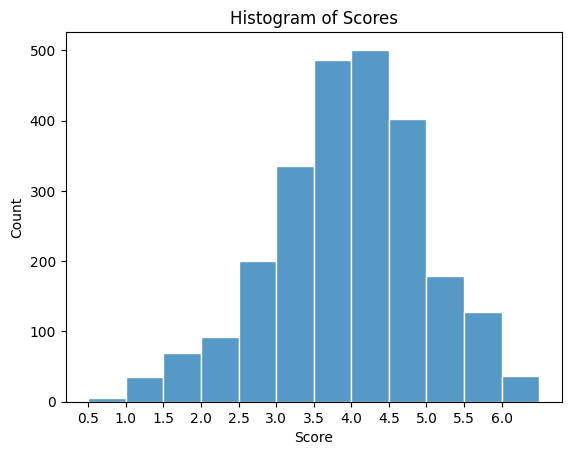

The score 0.5 is represented by only five data points, all of which register as zero.

Value counts % score
4.0    20.28
3.5    19.67
4.5    16.27
3.0    13.60
2.5     8.13
5.0     7.24
5.5     5.18
2.0     3.72
1.5     2.79
6.0     1.50
1.0     1.42
0.5     0.20
Name: proportion, dtype: float64


In [8]:
print(f'The average score is {train_scores.score.mean().round(2)}. The median is {train_scores.score.median()}')

sns.histplot(train_scores.score, bins=12, edgecolor='white', binwidth=0.4999)
xticks = [0.5 * i for i in range(1, 13)]
plt.xticks(xticks)
plt.xlabel('Score');
plt.ylabel('Count');
plt.title('Histogram of Scores')

print(f'There are {train_scores.score.nunique()} possible values for essay score:', 
      sorted(train_scores.score.unique()), '\n\n')

plt.show()
print('The score 0.5 is represented by only five data points, all of which register as zero.\n')
# print('Changing type to Categorical:\n', train_scores.score.unique())

print("Value counts %", f"{np.round(100 * train_scores.score.value_counts(normalize=True),2)}")

### train_logs

In [9]:
train_logs.head()

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count,num_events,total_time_mins,total_action_time_mins,mean_action_time_ms,chars_product,chars_per_min_product,chars_process,chars_per_min_process,words_per_min_product,words_per_min_process,sentences_per_min_process,sentences_per_min_product,paragraphs_per_min_process,num_pauses,pauses_per_min,pause_time_proportion_perc,mean_pause_length,mean_pause_length_btw_paragraphs,mean_pause_length_btw_sentences,mean_pause_length_btw_words,mean_pause_length_w_in_words,deletions,deletions_per_min,mean_length_deletions,distant_deletions,deletions_proportion_perc,imm_deletions,distant_deletion_ratio,product_process_ratio,p_bursts,r_bursts,p_bursts_per_min,r_bursts_per_min,mean_p_bursts_chars,mean_r_bursts_chars,p_bursts_proportion_perc,r_bursts_proportion_perc,std_chars_interval,coded_essay_str,len_essay,num_spaces,num_?,num_.,"num_""",num_;,num_punctuation
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0,2557,30.0,5.0,116.2,1528.0,50.9,2017.0,67.2,8.5,11.6,0.7,21.8,0.1,124.0,4.1,65.7,9537.1,19790.5,8271.9,1835.9,780.7,96.0,3.2,4.3,3.0,8.5,93.0,0.0,0.8,16.0,7.0,0.5,0.2,28.1,25.9,4.5,2.0,5.2,qqqqqqqqq qq qqqqq qq qqqq qqqq. qqqqqq qqq q...,1517,262,0,15,0,1,27
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0,2557,30.0,5.0,116.2,1528.0,50.9,2017.0,67.2,8.5,11.6,0.7,21.8,0.1,124.0,4.1,65.7,9537.1,19790.5,8271.9,1835.9,780.7,96.0,3.2,4.3,3.0,8.5,93.0,0.0,0.8,16.0,7.0,0.5,0.2,28.1,25.9,4.5,2.0,5.2,qqqqqqqqq qq qqqqq qq qqqq qqqq. qqqqqq qqq q...,1517,262,0,15,0,1,27
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0,2557,30.0,5.0,116.2,1528.0,50.9,2017.0,67.2,8.5,11.6,0.7,21.8,0.1,124.0,4.1,65.7,9537.1,19790.5,8271.9,1835.9,780.7,96.0,3.2,4.3,3.0,8.5,93.0,0.0,0.8,16.0,7.0,0.5,0.2,28.1,25.9,4.5,2.0,5.2,qqqqqqqqq qq qqqqq qq qqqq qqqq. qqqqqq qqq q...,1517,262,0,15,0,1,27
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1,2557,30.0,5.0,116.2,1528.0,50.9,2017.0,67.2,8.5,11.6,0.7,21.8,0.1,124.0,4.1,65.7,9537.1,19790.5,8271.9,1835.9,780.7,96.0,3.2,4.3,3.0,8.5,93.0,0.0,0.8,16.0,7.0,0.5,0.2,28.1,25.9,4.5,2.0,5.2,qqqqqqqqq qq qqqqq qq qqqq qqqq. qqqqqq qqq q...,1517,262,0,15,0,1,27
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1,2557,30.0,5.0,116.2,1528.0,50.9,2017.0,67.2,8.5,11.6,0.7,21.8,0.1,124.0,4.1,65.7,9537.1,19790.5,8271.9,1835.9,780.7,96.0,3.2,4.3,3.0,8.5,93.0,0.0,0.8,16.0,7.0,0.5,0.2,28.1,25.9,4.5,2.0,5.2,qqqqqqqqq qq qqqqq qq qqqq qqqq. qqqqqq qqq q...,1517,262,0,15,0,1,27


#### train_logs --> simplified_train_logs

Ultimately, we will retain only a single row for each essay:

In [10]:
redundant_vars = ['num_pauses', 'chars_process', 'chars_product']
train_logs.drop(redundant_vars, axis=1, inplace=True)

original_cols_ex_id = ['event_id', 'down_time', 'up_time', 'action_time', 'activity',
                       'down_event', 'up_event', 'text_change', 'cursor_position', 'word_count']

simplified_train_logs = train_logs.drop(original_cols_ex_id, axis=1)

simplified_train_logs.drop_duplicates(inplace=True)
simplified_train_logs.reset_index(drop=True, inplace=True)

print("\nNumber of features in train_logs vs simplified_train_logs:",len(train_logs.columns), 'vs', len(simplified_train_logs.columns), '\n')
print("Number of rows in train_logs vs simplified_train_logs:",train_logs.shape[0], 'vs', simplified_train_logs.shape[0], '\n')
simplified_train_logs.head()


Number of features in train_logs vs simplified_train_logs: 54 vs 44 

Number of rows in train_logs vs simplified_train_logs: 8405898 vs 2471 



,id,num_events,total_time_mins,total_action_time_mins,mean_action_time_ms,chars_per_min_product,chars_per_min_process,words_per_min_product,words_per_min_process,sentences_per_min_process,sentences_per_min_product,paragraphs_per_min_process,pauses_per_min,pause_time_proportion_perc,mean_pause_length,mean_pause_length_btw_paragraphs,mean_pause_length_btw_sentences,mean_pause_length_btw_words,mean_pause_length_w_in_words,deletions,deletions_per_min,mean_length_deletions,distant_deletions,deletions_proportion_perc,imm_deletions,distant_deletion_ratio,product_process_ratio,p_bursts,r_bursts,p_bursts_per_min,r_bursts_per_min,mean_p_bursts_chars,mean_r_bursts_chars,p_bursts_proportion_perc,r_bursts_proportion_perc,std_chars_interval,coded_essay_str,len_essay,num_spaces,num_?,num_.,"num_""",num_;,num_punctuation
0,001519c8,2557,30.0,5.0,116.2,50.9,67.2,8.5,11.6,0.7,21.8,0.1,4.1,65.7,9537.1,19790.5,8271.9,1835.9,780.7,96.0,3.2,4.3,3.0,8.5,93.0,0.0,0.8,16.0,7.0,0.5,0.2,28.1,25.9,4.5,2.0,5.2,qqqqqqqqq qq qqqqq qq qqqq qqqq. qqqqqq qqq q...,1517,262,0,15,0,1,27
1,0022f953,2454,29.8,4.6,112.2,56.2,65.1,10.7,12.4,0.6,17.9,0.2,2.7,65.8,14521.8,NaN,3197.7,1207.0,784.3,82.0,2.8,3.2,8.0,0.0,74.0,0.1,0.9,8.0,20.0,0.3,0.7,34.9,37.2,3.1,8.3,8.3,"qqqq qq qqqqqqqqqqq ? qq qq qqq qqq qqq, qqqqq...",1673,350,3,13,6,0,46
2,0042269b,4136,29.5,7.0,101.8,87.7,119.4,13.7,18.6,0.7,20.9,0.6,2.6,62.8,14430.7,4804.0,3315.3,1637.2,492.0,97.0,3.3,4.5,5.0,0.0,92.0,0.1,0.7,17.0,47.0,0.6,1.6,39.9,39.4,4.1,12.1,3.7,qqqqqqqqqqq qq qqqqq qqqqqqqqq qq qqqqqqqqqqq ...,2587,404,0,19,2,0,40
3,0059420b,1556,23.4,3.2,121.8,49.3,56.3,8.8,10.4,0.6,13.0,0.1,3.7,54.7,8828.4,61128.7,14315.4,2824.9,1199.7,66.0,2.8,2.3,1.0,0.0,65.0,0.0,0.9,4.0,3.0,0.2,0.1,27.5,28.7,3.4,2.1,2.8,qq qqqqqqq qqqqqq qqqqqqqqqqqqq qqqq q qqqq qq...,1154,207,0,12,0,0,16
4,0075873a,2531,27.7,5.2,123.9,51.4,70.1,9.1,12.2,0.9,24.7,0.4,3.2,62.9,11880.3,37640.0,12462.1,2293.4,1212.0,58.0,2.1,8.9,8.0,0.0,50.0,0.1,0.7,16.0,8.0,0.6,0.3,47.2,32.2,9.1,3.0,3.8,"qqqqqqqqqqq qq qqq qqqqq qq qqqqqqqqqq, qqq qq...",1425,251,2,14,0,0,48


#### down_time, up_time, action_time

These 3 features have been used to create several other features in the `keystroke-measures` file, 

namely `total_time_mins, total_action_time_mins, mean_action_time_ms` and features related to pauses, deletions and bursts.

#### activity

Values like `Move From [x1, y1] To [x2, y2]` in the field `activity` refer to events where a section of text has been moved to a new location.

In [11]:
print("The number of events with this kind of activity is only:", 
      train_logs[train_logs['activity'].str.startswith('Move From [')].activity.count())

The number of events with this kind of activity is only: 46


In [12]:
print("Value counts for other types of activity are:\n\n", 
      train_logs[~train_logs['activity'].str.startswith('Move')].activity.value_counts())

Value counts for other types of activity are:

 activity
Input            6726796
Remove/Cut        970158
Nonproduction     703851
Replace             4448
Paste                599
Name: count, dtype: int64


In [13]:
# sns.histplot(train_logs[~train_logs['activity'].str.startswith('Move')].activity);
# plt.title('Count of Event Activity Categories ex "Move From [x1, y1] To [x2, y2]"');

#### down_event, up_event, text_change 

The documentation specifies that all alphanumeric character inputs have been substituted with the "anonymous" character `q`.

In [14]:
train_logs.text_change.value_counts()[:10]

text_change
q           6128208
            1376829
NoChange     703851
.             67797
,             54797
\n            27977
'             13192
"              4659
-              4492
?              3507
Name: count, dtype: int64

In [15]:
train_logs.down_event.unique()

array(['Leftclick', 'Shift', 'q', 'Space', 'Backspace', '.', ',', 'Enter',
       'ArrowLeft', "'", ';', 'ArrowRight', '-', '?', 'Tab', '"',
       'ArrowUp', 'ArrowDown', 'Rightclick', '=', 'CapsLock', 'Control',
       'c', 'v', '/', 'Delete', ':', 'z', '[', '$', '(', ')', '+', 'Home',
       'End', '\\', 'Meta', '*', '&', 'AudioVolumeMute', 'x', '!',
       'Insert', 'MediaPlayPause', 'NumLock', '%', 'V', '>', 'Alt',
       'AudioVolumeUp', 'ContextMenu', 'AudioVolumeDown', 'a', '<',
       'PageDown', ']', 'Middleclick', '@', 'F12', 'j', '\x96', 'Dead',
       't', 's', 'n', 'y', '{', 'ScrollLock', '¿', 'Process', '}',
       'MediaTrackPrevious', 'MediaTrackNext', 'F3', '^', 'Unidentified',
       'Cancel', '2', 'i', 'd', 'r', 'e', '`', '\x9b', 'm', '#', '~',
       'PageUp', 'T', 'A', 'b', 'S', 'ModeChange', '_', 'Escape', 'F11',
       'Unknownclick', 'AltGraph', 'F10', 'h', 'F15', 'Clear', 'OS', 'F',
       'C', 'o', 'Ä±', 'f', 'u', 'w', 'p', 'g', 'M', 'l', '|',
       'â\x80\x

In [16]:
train_logs.down_event.value_counts()[:10]

down_event
q             5365319
Space         1207128
Backspace      964089
Shift          334227
ArrowRight     121338
Leftclick       91126
ArrowLeft       63217
.               59586
,               46806
ArrowDown       30874
Name: count, dtype: int64

- **Hypothesis to explore**: Better handling of keyboard shortcuts could be associated with higher competence

In [17]:
# We will focus on 'Control key' events
train_logs['num_control_key'] = train_logs.groupby('id')['down_event'].transform(lambda x: (x == 'Control').sum())

simplified_train_logs = simplified_train_logs.merge(train_logs[['id', 'num_control_key']].drop_duplicates(), on='id', how='left')
simplified_train_logs.drop('id', axis=1, inplace=True)

In [18]:
# Verifying that the choice between 'down_event' and 'up_event' is inconsequential
is_choice_irrelevant = (train_logs.groupby('id')['down_event'].transform(lambda x: (x == 'Control').sum())
                        == train_logs.groupby('id')['up_event'].transform(lambda x: (x == 'Control').sum())).mean()

print(f"The result of is_choice_irrelevant: {bool(is_choice_irrelevant)},", 
      "confirms that the values for 'down_event' and 'up_event' coincide when either of them is 'Control'.")

The result of is_choice_irrelevant: True, confirms that the values for 'down_event' and 'up_event' coincide when either of them is 'Control'.


In [19]:
# Observing values of new feature 'num_control_key'
# fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# sns.histplot(simplified_train_logs.num_control_key, binwidth=1, ax=axes[0])
# axes[0].set_title('Histogram - num_control_key events / essay')

# sns.histplot(simplified_train_logs[simplified_train_logs.num_control_key > 0].num_control_key, binwidth=1, ax=axes[1])
# axes[1].set_title('Histogram - num_control_key > 0');

# print("Percentage of essays with at least one event ('down_event') involving the Control key:",
#       f"{np.round(100 * len(simplified_train_logs[simplified_train_logs.num_control_key != 0]) / len(simplified_train_logs), 1)}%\n\n")

In [20]:
# Checking correlation of 'num_control_key' vs 'score'
# fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# sns.boxplot(x=train_scores.score, y=simplified_train_logs.num_control_key, palette='dark', ax=axes[0]);
# sns.barplot(x=train_scores.score, y=simplified_train_logs.num_control_key, ci=None, palette='dark', ax=axes[1]);

We can infer that there is no discernible correlation between use of 'Control key' vs 'score'. 

Nevertheless, we will keep the feature for potential interactions with other features.

#### num_events

In [21]:
# print(f'The average number of events per essay is {np.round(simplified_train_logs.num_events.mean(), 0)}')
# sns.histplot(data=simplified_train_logs, x='num_events', bins=20);

For machine learning models, it becomes challenging to effectively learn and make accurate predictions when certain features

exhibit a range of values with infrequent occurrences. We will try some approaches to mitigate that handicap, later on.

Is there a correlation between `num_events` and `score`?

In [22]:
# print("\n\t\t\t\tThe graph on the right illustrates the average value of num_events for each score.\n\n")

# fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# sns.boxplot(x=train_scores.score, y=simplified_train_logs.num_events, palette='dark', ax=axes[0]);
# sns.barplot(x=train_scores.score, y=simplified_train_logs.num_events, ci=None, palette='dark', ax=axes[1]);

Indeed, there appears to be a positive correlation between `num_events` and `score`.

Now, let's check possible correlations between the target variable `score` and the rest of features:

In [23]:
# for column in simplified_train_logs.columns:
#     if column not in ('num_control_key', 'num_events'):
#         fig, axes = plt.subplots(1, 2, figsize=(10, 3))
#         sns.boxplot(x=train_scores.score, y=simplified_train_logs[column], palette='dark', ax=axes[0]);
#         sns.barplot(x=train_scores.score, y=simplified_train_logs[column], ci=None, palette='dark', ax=axes[1]);
#         plt.tight_layout()
#         plt.show()

We can observe clearly some positive correlations with the features: `total_action_time_mins, chars_per_min_product,`

`chars_per_min_process, words_per_min_product, words_per_min_process, sentences_per_min_process, sentences_per_min_product,`

`deletions, deletions_per_min, imm_deletions, p_bursts, r_bursts, p_bursts_per_min, r_bursts_per_min,` 

`bursts_proportion_perc, r_bursts_proportion_perc`. There are negative correlations with the following features, as well:

`pause_time_proportion_perc, mean_pause_length_btw_sentences, mean_pause_length_btw_words,` 

`mean_pause_length_w_in_words`.

Afterwards, correlations among those features will be analyzed, and some of them will be descarded as a result.

- **Other hypothesis to explore**:
    *  Best writers have more clarity of thought -> less corrections - keystroke features
    
    *  Best writers spend a larger share of time reviewing - keystroke features

    *  Best writers spend a larger share of time thinking, in pause - keystroke features
    
    *  Best writers spend a larger share of time in bursts (better short-term memory) - keystroke features
    
    *  Volume-related events: tendency to get distracted - tiny sample 
    
    *  Volume-related events: focused if shutting down noise  - tiny sample
    
    *  Those with more periods of inactivity have lower performance - keystroke features
    
<br>


Several hypotheses were rejected due to the limited sample sizes, while others required the introduction of novel features

(keystroke features created in the file 'keystroke-measures'). The efficacy of these newly introduced features will be

assessed by machine learning models to ascertain their utility or lack thereof.

## Feature Engineering

In [24]:
print("Null Values found in simplified_train_logs:\n")
print(simplified_train_logs.isna().sum().sort_values(ascending=False)[:6])
simplified_train_logs.fillna(0, inplace=True)

Null Values found in simplified_train_logs:

mean_pause_length_btw_paragraphs    614
mean_r_bursts_chars                  30
mean_pause_length_btw_sentences      20
mean_p_bursts_chars                   9
mean_length_deletions                 1
distant_deletion_ratio                1
dtype: int64


In [25]:
simplified_train_logs.columns

Index(['num_events', 'total_time_mins', 'total_action_time_mins',
       'mean_action_time_ms', 'chars_per_min_product', 'chars_per_min_process',
       'words_per_min_product', 'words_per_min_process',
       'sentences_per_min_process', 'sentences_per_min_product',
       'paragraphs_per_min_process', 'pauses_per_min',
       'pause_time_proportion_perc', 'mean_pause_length',
       'mean_pause_length_btw_paragraphs', 'mean_pause_length_btw_sentences',
       'mean_pause_length_btw_words', 'mean_pause_length_w_in_words',
       'deletions', 'deletions_per_min', 'mean_length_deletions',
       'distant_deletions', 'deletions_proportion_perc', 'imm_deletions',
       'distant_deletion_ratio', 'product_process_ratio', 'p_bursts',
       'r_bursts', 'p_bursts_per_min', 'r_bursts_per_min',
       'mean_p_bursts_chars', 'mean_r_bursts_chars',
       'p_bursts_proportion_perc', 'r_bursts_proportion_perc',
       'std_chars_interval', 'coded_essay_str', 'len_essay', 'num_spaces',
       'num

In [26]:
# feature clusters
production_cluster = ['chars_per_min_product', 'chars_per_min_process', 'words_per_min_product', 
                      'words_per_min_process', 'sentences_per_min_process', 'sentences_per_min_product',
                      'paragraphs_per_min_process', 'num_control_key', 'num_events', 'total_time_mins',
                      'total_action_time_mins', 'mean_action_time_ms', 'product_process_ratio', 'std_chars_interval']
pause_cluster = ['pauses_per_min', 'pause_time_proportion_perc', 'mean_pause_length', 
                 'mean_pause_length_btw_paragraphs', 'mean_pause_length_btw_sentences',
                 'mean_pause_length_btw_words', 'mean_pause_length_w_in_words']
deletions_cluster = ['deletions', 'deletions_per_min', 'mean_length_deletions', 'distant_deletions', 
                     'deletions_proportion_perc', 'imm_deletions', 'distant_deletion_ratio']
bursts_cluster = ['p_bursts', 'r_bursts', 'p_bursts_per_min', 'r_bursts_per_min',
                  'mean_p_bursts_chars', 'mean_r_bursts_chars', 'p_bursts_proportion_perc', 
                  'r_bursts_proportion_perc']

feature_clusters = [production_cluster, pause_cluster, deletions_cluster, bursts_cluster]
feature_clusters_str = ['production cluster', 'pause cluster', 'deletions cluster', 'bursts cluster']

# Misfits have been added to production_cluster

In [27]:
# for i, feature_cluster in enumerate(feature_clusters):
#     pair_plot = sns.pairplot(simplified_train_logs[feature_cluster], corner=True)
#     pair_plot.fig.suptitle(f'Pairplot for {feature_clusters_str[i]}', y=1.005)

In [28]:
highly_correl_cols = ['chars_per_min_product', 'words_per_min_process', 'imm_deletions', 
                      'deletions_per_min', 'r_bursts_per_min']
simplified_train_logs.drop(highly_correl_cols, axis=1, inplace=True)
len(simplified_train_logs.columns)

39

In [29]:
# delete highly_correl_cols from feature_clusters
feature_clusters = [list(set(cluster) - set(highly_correl_cols)) for cluster in feature_clusters]

## Baselines 

#### Baseline with Random Forest Regressor

The challenge at hand offers two viable approaches for resolution: Classification or Regression. Given that the evaluation

metric is the root mean squared error (RMSE), our initial strategy involves approaching it as a Regression problem. To align 

with this choice, we will designate RMSE as both the metric for evaluation and the loss function where applicable.

In [30]:
# from sklearn.model_selection import KFold, cross_val_predict, cross_val_score
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import make_scorer, mean_squared_error

# rf = RandomForestRegressor(random_state=SEED)

# X = simplified_train_logs
# y = train_scores.score

# num_folds = 5
# kfold = KFold(n_splits=num_folds, shuffle=True, random_state=SEED)

# # Define custom scorer for RMSE
# rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)

# # Perform cross-validation with RMSE as the scoring metric and obtain predictions
# cv_predictions = cross_val_predict(rf, X, y, cv=kfold)

# # Display real values, predictions, max, and min predicted values for each fold
# for fold, (train_idx, test_idx) in enumerate(kfold.split(X, y)):
#     X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
#     y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
#     predictions = cv_predictions[test_idx]

#     print(f"\nFold {fold + 1}:")
# #     print("Real Values:", y_test.values)
# #     print("Predictions:", predictions)
#     print("Max Predicted Value:", np.round(np.max(predictions),1))
#     print("Min Predicted Value:", np.round(np.min(predictions),1))

#     # Calculate and print RMSE for the fold
#     fold_rmse = np.round(np.sqrt(mean_squared_error(y_test, predictions)),2)
#     print("Fold RMSE:", fold_rmse)

# # Display the cross-validation scores
# cv_scores = cross_val_score(rf, X, y, cv=kfold, scoring=rmse_scorer)
# print("\nCross-validation RMSE scores:", -cv_scores)  # Negate scores since make_scorer uses greater_is_better=False
# print("Mean RMSE:", np.round(-cv_scores.mean(), 2))  # Negate mean as well


**Results from the previous cell** (Baseline with Random Forest Regressor):

    Fold 1:
    Max Predicted Value: 5.4
    Min Predicted Value: 1.6
    Fold RMSE: 0.61

    Fold 2:
    Max Predicted Value: 5.4
    Min Predicted Value: 1.8
    Fold RMSE: 0.73

    Fold 3:
    Max Predicted Value: 5.2
    Min Predicted Value: 1.5
    Fold RMSE: 0.68

    Fold 4:
    Max Predicted Value: 5.3
    Min Predicted Value: 1.7
    Fold RMSE: 0.71

    Fold 5:
    Max Predicted Value: 5.2
    Min Predicted Value: 1.7
    Fold RMSE: 0.66

    Cross-validation RMSE scores: [0.61 0.73  0.68 0.71 0.66]


    Mean RMSE: 0.68

The **submission** using this Baseline (Random Forest Regressor) achieved a score of 0.648, placing it in the top 81% of submissions.

Note that the submission score is slightly better than the mean cross-validation score obtained using only the training set `train_logs`: 0.648 vs 0.68

#### Baseline with XGB Regressor

In [31]:
# from sklearn.model_selection import KFold
# from xgboost import XGBRegressor

# X = simplified_train_logs
# y = train_scores.score

# # Set the number of folds
# num_folds = 5

# # Instantiate the KFold cross-validator
# kf = KFold(n_splits=num_folds, shuffle=True, random_state=SEED)

# # Initialize lists to store results
# max_values = []
# min_values = []
# rmse_scores = []

# regr = XGBRegressor(random_state=SEED)

# # Perform cross-validation
# for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]

#     # Initialize lists to store errors for each fold
#     train_errors_fold = []
#     test_errors_fold = []

#     # Fit the model on the training data
#     regr.fit(X_train, y_train, eval_metric="rmse", eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)

#     # Get training and testing errors for each iteration of the current fold
#     train_errors_fold = regr.evals_result()["validation_0"]["rmse"]
#     test_errors_fold = regr.evals_result()["validation_1"]["rmse"]

#     # Make predictions on the test data
#     y_pred = regr.predict(X_test)

#     # Store max and min predicted values for each fold
#     max_values.append(np.round(np.max(y_pred), 2))
#     min_values.append(np.round(np.min(y_pred), 2))

#     # Calculate RMSE for the fold
#     rmse = np.round(np.sqrt(((y_test - y_pred) ** 2).mean()), 2)
#     rmse_scores.append(rmse)

#     # Print results for each fold
#     print(f"\nFold {fold}: Max Predicted Value: ", np.round(np.max(y_pred), 2), "; Min Predicted Value: ", np.round(np.min(y_pred), 2), f"; Fold RMSE: {rmse}")

#     # Plot training and testing errors for the current fold
#     fig, ax = plt.subplots(figsize=(5, 3))
#     ax.plot(train_errors_fold, label='Train')
#     ax.plot(test_errors_fold, label='Test')
#     ax.set_xlabel('Number of Iterations')
#     ax.set_ylabel('RMSE')
#     ax.legend()
#     plt.title(f'Fold {fold}: Training and Testing Errors vs Number of Iterations')
#     plt.show()

# # Print average RMSE across all folds
# print(f"\nCross-validation RMSE scores: {rmse_scores}")
# print(f"\nMean RMSE: {np.round(np.mean(rmse_scores), 2)}")


**Results from the previous cell** (Baseline with XGBoost Regressor):

    Fold 1: Max Predicted Value:  5.55 ; Min Predicted Value:  1.04 ; Fold RMSE: 0.73

    Fold 2: Max Predicted Value:  5.7 ; Min Predicted Value:  1.5 ; Fold RMSE: 0.73

    Fold 3: Max Predicted Value:  5.76 ; Min Predicted Value:  1.32 ; Fold RMSE: 0.7

    Fold 4: Max Predicted Value:  5.66 ; Min Predicted Value:  1.46 ; Fold RMSE: 0.72

    Fold 5: Max Predicted Value:  5.67 ; Min Predicted Value:  1.36 ; Fold RMSE: 0.76

    Cross-validation RMSE scores: [0.73, 0.73, 0.7, 0.72, 0.76]

    Mean RMSE: 0.73

The **submission** using this Baseline (XGBoost Regressor) achieved a score of 0.72, worse than the Baseline with Random Forest (0.648).

In this case, the submission score is almost equal to the mean cross-validation score: 0.72 vs 0.73

It's important to note that, during the preparation for submission, predictions have been constrained to align with the 

nearest potential target value. This restriction will remain in place for future experiments.

## More experiments with XGB Regressor

Moving forward, experiment validation will hinge on their cross-validation RMSE scores. Those that demonstrate improved

efficiency without compromising the overall outcome will be integrated into the training harness, as well.

### Feature selection

We employ two distinct methods to assess the significance of features in our dataset: XGBoost's Feature Importance and sklearn's Permutation Importance. 

Of the two methods, we prioritize the latter for its robust evaluation of feature importance through the permutation of data, providing a more comprehensive and reliable measure.

We will obtain them after training the baseline XGB Regressor model on the whole dataset. Afterwards, we will analyze each cluster of features to assess which 

features may be irrelevant. The process will be repeated after deleting them, as long as the model's performance does not deteriorate.

#### 1st iteration

In [32]:
# from xgboost import XGBRegressor

# X = simplified_train_logs
# y = train_scores.score

# regr = XGBRegressor(random_state=SEED)

# # Fit the model on the whole dataset
# regr.fit(X, y);

In [33]:
# Generating feature importances to be analyzed later
# xgb_feature_importance_dict = dict(zip(X.columns, regr.feature_importances_))
# xgb_feature_importance = {key: round(value, 2) for key, value in xgb_feature_importance_dict.items()}
# xgb_feature_importance = dict(sorted(xgb_feature_importance.items(), key=lambda x: x[1], reverse=True))

# from sklearn.inspection import permutation_importance
# result = permutation_importance(regr, X, y, n_repeats=5, random_state=SEED)
# result = dict(zip(X.columns, result.importances_mean))
# result = {key: round(value, 2) for key, value in result.items()}
# permutation_importances = dict(sorted(result.items(), key=lambda x: x[1], reverse=True))

In [34]:
# permutation_importances

In [35]:
# {key: value for key, value in xgb_feature_importance.items() if key in production_cluster}

In [36]:
# {key: value for key, value in permutation_importances.items() if key in production_cluster}

Conclusions for production cluster: - The significance of 'num_control_key', 'product_process_ratio' and 

'sentences_per_min_process' is marginal in both instances and will be removed.

In [37]:
# {key: value for key, value in xgb_feature_importance.items() if key in pause_cluster}

In [38]:
# {key: value for key, value in permutation_importances.items() if key in pause_cluster}

Conclusions for pause cluster: Both methods attribute slight importance to this group of features. 

'mean_pause_length_btw_paragraphs' will be the first one to go.

In [39]:
# {key: value for key, value in xgb_feature_importance.items() if key in deletions_cluster}

In [40]:
# {key: value for key, value in permutation_importances.items() if key in deletions_cluster}

Conclusions for deletions cluster: 'deletions_proportion_perc' shows a null value in both cases. To be deleted

In [41]:
# {key: value for key, value in xgb_feature_importance.items() if key in bursts_cluster}

In [42]:
# {key: value for key, value in permutation_importances.items() if key in bursts_cluster}

Conclusions for bursts cluster: Since 'p_bursts_per_min' is useless according to Permutation Importance, it will be eliminated in the next iteration.

#### 2nd iteration

In [43]:
# from sklearn.model_selection import KFold
# from xgboost import XGBRegressor

# X = simplified_train_logs[['num_events', 'total_time_mins', 'total_action_time_mins',
#        'mean_action_time_ms', 'chars_per_min_process', 'words_per_min_product',
#        'sentences_per_min_product',
#        'paragraphs_per_min_process', 'pauses_per_min',
#        'pause_time_proportion_perc', 'mean_pause_length',
#        'mean_pause_length_btw_sentences',
#        'mean_pause_length_btw_words', 'mean_pause_length_w_in_words',
#        'deletions', 'mean_length_deletions', 'distant_deletions',
#        'distant_deletion_ratio',
#        'p_bursts', 'r_bursts',
#        'mean_p_bursts_chars', 'mean_r_bursts_chars',
#        'p_bursts_proportion_perc', 'r_bursts_proportion_perc',
#        'std_chars_interval']]

# y = train_scores.score

# # Set the number of folds
# num_folds = 5

# # Instantiate the KFold cross-validator
# kf = KFold(n_splits=num_folds, shuffle=True, random_state=SEED)

# # Initialize lists to store results
# rmse_scores = []

# regr = XGBRegressor(random_state=SEED)

# # Perform cross-validation
# for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]

#     # Fit the model on the training data
#     regr.fit(X_train, y_train, eval_metric="rmse", eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)

#     # Get training and testing errors for each iteration of the current fold
#     train_errors_fold = regr.evals_result()["validation_0"]["rmse"]
#     test_errors_fold = regr.evals_result()["validation_1"]["rmse"]

#     # Make predictions on the test data
#     y_pred = regr.predict(X_test)

#     # Calculate RMSE for the fold
#     rmse = np.round(np.sqrt(((y_test - y_pred) ** 2).mean()), 2)
#     rmse_scores.append(rmse)

# # Print average RMSE across all folds
# print(f"\nCross-validation RMSE scores: {rmse_scores}")
# print(f"\nMean RMSE: {np.round(np.mean(rmse_scores), 2)}")

After eliminating 7 features the performance of the model stays the same: Mean RMSE = 0.73

In [44]:
# regr.fit(X,y);

In [45]:
# # Generating feature importances to be analyzed later
# xgb_feature_importance_dict = dict(zip(X.columns, regr.feature_importances_))
# xgb_feature_importance = {key: round(value, 2) for key, value in xgb_feature_importance_dict.items()}
# xgb_feature_importance = dict(sorted(xgb_feature_importance.items(), key=lambda x: x[1], reverse=True))

# from sklearn.inspection import permutation_importance
# result = permutation_importance(regr, X, y, n_repeats=5, random_state=SEED)
# result = dict(zip(X.columns, result.importances_mean))
# result = {key: round(value, 2) for key, value in result.items()}
# permutation_importances = dict(sorted(result.items(), key=lambda x: x[1], reverse=True))

In [46]:
# {key: value for key, value in xgb_feature_importance.items() if key in production_cluster}

In [47]:
# {key: value for key, value in permutation_importances.items() if key in production_cluster}

In [48]:
# {key: value for key, value in xgb_feature_importance.items() if key in pause_cluster}

In [49]:
# {key: value for key, value in permutation_importances.items() if key in pause_cluster}

In [50]:
# {key: value for key, value in xgb_feature_importance.items() if key in deletions_cluster}

In [51]:
# {key: value for key, value in permutation_importances.items() if key in deletions_cluster}

In [52]:
# {key: value for key, value in xgb_feature_importance.items() if key in bursts_cluster}

In [53]:
# {key: value for key, value in permutation_importances.items() if key in bursts_cluster}

Conclusions : Next candidates for deletion, in order: 'distant_deletion_ratio', 'mean_pause_length_btw_words', 

'r_bursts_proportion_perc', 'mean_action_time_ms', 'std_chars_interval' ,'total_time_mins', 'paragraphs_per_min_process'.

#### 3rd iteration

In [54]:
# from sklearn.model_selection import KFold
# from xgboost import XGBRegressor

# X = simplified_train_logs[['num_events', 'total_action_time_mins',
#        'chars_per_min_process', 'words_per_min_product',
#        'sentences_per_min_product',
#        'pauses_per_min',
#        'pause_time_proportion_perc', 'mean_pause_length',
#        'mean_pause_length_btw_sentences',
#        'mean_pause_length_w_in_words',
#        'deletions', 'mean_length_deletions', 'distant_deletions',
#        'p_bursts', 'r_bursts',
#        'mean_p_bursts_chars', 'mean_r_bursts_chars',
#        'p_bursts_proportion_perc']]

# y = train_scores.score

# # Set the number of folds
# num_folds = 5

# # Instantiate the KFold cross-validator
# kf = KFold(n_splits=num_folds, shuffle=True, random_state=SEED)

# # Initialize lists to store results
# rmse_scores = []

# regr = XGBRegressor(random_state=SEED)

# # Perform cross-validation
# for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]

#     # Fit the model on the training data
#     regr.fit(X_train, y_train, eval_metric="rmse", eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)

#     # Get training and testing errors for each iteration of the current fold
#     train_errors_fold = regr.evals_result()["validation_0"]["rmse"]
#     test_errors_fold = regr.evals_result()["validation_1"]["rmse"]

#     # Make predictions on the test data
#     y_pred = regr.predict(X_test)

#     # Calculate RMSE for the fold
#     rmse = np.round(np.sqrt(((y_test - y_pred) ** 2).mean()), 2)
#     rmse_scores.append(rmse)

# # Print average RMSE across all folds
# print(f"\nCross-validation RMSE scores: {rmse_scores}")
# print(f"\nMean RMSE: {np.round(np.mean(rmse_scores), 2)}")

After deleting the aforementioned 7 features, performance continues at 0.73.

In [55]:
# regr.fit(X,y);

In [56]:
# # Generating feature importances to be analyzed later
# xgb_feature_importance_dict = dict(zip(X.columns, regr.feature_importances_))
# xgb_feature_importance = {key: round(value, 2) for key, value in xgb_feature_importance_dict.items()}
# xgb_feature_importance = dict(sorted(xgb_feature_importance.items(), key=lambda x: x[1], reverse=True))

# from sklearn.inspection import permutation_importance
# result = permutation_importance(regr, X, y, n_repeats=5, random_state=SEED)
# result = dict(zip(X.columns, result.importances_mean))
# result = {key: round(value, 2) for key, value in result.items()}
# permutation_importances = dict(sorted(result.items(), key=lambda x: x[1], reverse=True))

In [57]:
# {key: value for key, value in xgb_feature_importance.items() if key in production_cluster}

In [58]:
# {key: value for key, value in permutation_importances.items() if key in production_cluster}

In [59]:
# {key: value for key, value in xgb_feature_importance.items() if key in pause_cluster}

In [60]:
# {key: value for key, value in permutation_importances.items() if key in pause_cluster}

In [61]:
# {key: value for key, value in xgb_feature_importance.items() if key in deletions_cluster}

In [62]:
# {key: value for key, value in permutation_importances.items() if key in deletions_cluster}

In [63]:
# {key: value for key, value in xgb_feature_importance.items() if key in bursts_cluster}

In [64]:
# {key: value for key, value in permutation_importances.items() if key in bursts_cluster}

Conclusions : Next candidates for deletion, in order: 'distant_deletions', 'mean_pause_length', 'mean_p_bursts_chars'.

In addition to the criteria previously mentioned, we are now prioritizing removal of features within richer clusters. 

#### 4th iteration

In [65]:
# from sklearn.model_selection import KFold
# from xgboost import XGBRegressor

# X = simplified_train_logs[['num_events', 'total_action_time_mins',
#        'chars_per_min_process', 'words_per_min_product',
#        'sentences_per_min_product',
#        'pauses_per_min',
#        'pause_time_proportion_perc',
#        'mean_pause_length_btw_sentences',
#        'mean_pause_length_w_in_words',
#        'deletions', 'mean_length_deletions',
#        'p_bursts', 'r_bursts',
#        'mean_r_bursts_chars',
#        'p_bursts_proportion_perc']]

# y = train_scores.score

# # Set the number of folds
# num_folds = 5

# # Instantiate the KFold cross-validator
# kf = KFold(n_splits=num_folds, shuffle=True, random_state=SEED)

# # Initialize lists to store results
# rmse_scores = []

# regr = XGBRegressor(random_state=SEED)

# # Perform cross-validation
# for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]

#     # Fit the model on the training data
#     regr.fit(X_train, y_train, eval_metric="rmse", eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)

#     # Get training and testing errors for each iteration of the current fold
#     train_errors_fold = regr.evals_result()["validation_0"]["rmse"]
#     test_errors_fold = regr.evals_result()["validation_1"]["rmse"]

#     # Make predictions on the test data
#     y_pred = regr.predict(X_test)

#     # Calculate RMSE for the fold
#     rmse = np.round(np.sqrt(((y_test - y_pred) ** 2).mean()), 2)
#     rmse_scores.append(rmse)

# # Print average RMSE across all folds
# print(f"\nCross-validation RMSE scores: {rmse_scores}")
# print(f"\nMean RMSE: {np.round(np.mean(rmse_scores), 2)}")

After deleting 3 more features, the model performance drops slightly, from 0.73 to 0.74. It looks like an acceptable tradeoff.

In [66]:
# print(f"Now the dataset contains {len(X.columns)} features.")

In [67]:
# regr.fit(X,y);

In [68]:
# # Generating feature importances to be analyzed later
# xgb_feature_importance_dict = dict(zip(X.columns, regr.feature_importances_))
# xgb_feature_importance = {key: round(value, 2) for key, value in xgb_feature_importance_dict.items()}
# xgb_feature_importance = dict(sorted(xgb_feature_importance.items(), key=lambda x: x[1], reverse=True))

# from sklearn.inspection import permutation_importance
# result = permutation_importance(regr, X, y, n_repeats=5, random_state=SEED)
# result = dict(zip(X.columns, result.importances_mean))
# result = {key: round(value, 2) for key, value in result.items()}
# permutation_importances = dict(sorted(result.items(), key=lambda x: x[1], reverse=True))

In [69]:
# {key: value for key, value in xgb_feature_importance.items() if key in production_cluster}

In [70]:
# {key: value for key, value in permutation_importances.items() if key in production_cluster}

In [71]:
# {key: value for key, value in xgb_feature_importance.items() if key in pause_cluster}

In [72]:
# {key: value for key, value in permutation_importances.items() if key in pause_cluster}

In [73]:
# {key: value for key, value in xgb_feature_importance.items() if key in deletions_cluster}

In [74]:
# {key: value for key, value in permutation_importances.items() if key in deletions_cluster}

In [75]:
# {key: value for key, value in xgb_feature_importance.items() if key in bursts_cluster}

In [76]:
# {key: value for key, value in permutation_importances.items() if key in bursts_cluster}

Conclusions: It will not be surprising if the model can't afford losing more features. However, the following features appear to be prime candidates for deletion 

in the next iteration: 'r_bursts', 'mean_length_deletions', 'pauses_per_min', 'total_action_time_mins'.

#### 5th iteration

In [77]:
# from sklearn.model_selection import KFold
# from xgboost import XGBRegressor

# X = simplified_train_logs[['num_events',
#        'chars_per_min_process', 'words_per_min_product',
#        'sentences_per_min_product',
#        'pause_time_proportion_perc',
#        'mean_pause_length_btw_sentences',
#        'mean_pause_length_w_in_words',
#        'deletions',
#        'p_bursts',
#        'mean_r_bursts_chars',
#        'p_bursts_proportion_perc']]
# y = train_scores.score

# # Set the number of folds
# num_folds = 5

# # Instantiate the KFold cross-validator
# kf = KFold(n_splits=num_folds, shuffle=True, random_state=SEED)

# # Initialize lists to store results
# rmse_scores = []

# regr = XGBRegressor(random_state=SEED)

# # Perform cross-validation
# for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]

#     # Fit the model on the training data
#     regr.fit(X_train, y_train, eval_metric="rmse", eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)

#     # Get training and testing errors for each iteration of the current fold
#     train_errors_fold = regr.evals_result()["validation_0"]["rmse"]
#     test_errors_fold = regr.evals_result()["validation_1"]["rmse"]

#     # Make predictions on the test data
#     y_pred = regr.predict(X_test)

#     # Calculate RMSE for the fold
#     rmse = np.round(np.sqrt(((y_test - y_pred) ** 2).mean()), 2)
#     rmse_scores.append(rmse)

# # Print average RMSE across all folds
# print(f"\nCross-validation RMSE scores: {rmse_scores}")
# print(f"\nMean RMSE: {np.round(np.mean(rmse_scores), 2)}")

The model score goes back to a Mean RMSE of 0.73 after deleting 4 more features. 

In [78]:
# print(f"Now the dataset contains {len(X.columns)} features.")

In [79]:
# regr.fit(X,y);

In [80]:
# # Generating feature importances to be analyzed later
# xgb_feature_importance_dict = dict(zip(X.columns, regr.feature_importances_))
# xgb_feature_importance = {key: round(value, 2) for key, value in xgb_feature_importance_dict.items()}
# xgb_feature_importance = dict(sorted(xgb_feature_importance.items(), key=lambda x: x[1], reverse=True))

# from sklearn.inspection import permutation_importance
# result = permutation_importance(regr, X, y, n_repeats=5, random_state=SEED)
# result = dict(zip(X.columns, result.importances_mean))
# result = {key: round(value, 2) for key, value in result.items()}
# permutation_importances = dict(sorted(result.items(), key=lambda x: x[1], reverse=True))

In [81]:
# {key: value for key, value in xgb_feature_importance.items() if key in production_cluster}

In [82]:
# {key: value for key, value in permutation_importances.items() if key in production_cluster}

In [83]:
# {key: value for key, value in xgb_feature_importance.items() if key in pause_cluster}

In [84]:
# {key: value for key, value in permutation_importances.items() if key in pause_cluster}

In [85]:
# {key: value for key, value in xgb_feature_importance.items() if key in deletions_cluster}

In [86]:
# {key: value for key, value in permutation_importances.items() if key in deletions_cluster}

In [87]:
# {key: value for key, value in xgb_feature_importance.items() if key in bursts_cluster}

In [88]:
# {key: value for key, value in permutation_importances.items() if key in bursts_cluster}

Conclusions: Next variables to potentially dispense with: 'mean_pause_length_btw_sentences', 'mean_r_bursts_chars', 'deletions', 'p_bursts_proportion_perc'.

#### 6th iteration

In [89]:
# from sklearn.model_selection import KFold
# from xgboost import XGBRegressor

# X = simplified_train_logs[['num_events',
#        'chars_per_min_process', 'words_per_min_product',
#        'sentences_per_min_product',
#        'pause_time_proportion_perc',
#        'mean_pause_length_w_in_words',
#        'p_bursts']]

# y = train_scores.score

# # Set the number of folds
# num_folds = 5

# # Instantiate the KFold cross-validator
# kf = KFold(n_splits=num_folds, shuffle=True, random_state=SEED)

# # Initialize lists to store results
# rmse_scores = []

# regr = XGBRegressor(random_state=SEED)

# # Perform cross-validation
# for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]

#     # Fit the model on the training data
#     regr.fit(X_train, y_train, eval_metric="rmse", eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)

#     # Get training and testing errors for each iteration of the current fold
#     train_errors_fold = regr.evals_result()["validation_0"]["rmse"]
#     test_errors_fold = regr.evals_result()["validation_1"]["rmse"]

#     # Make predictions on the test data
#     y_pred = regr.predict(X_test)

#     # Calculate RMSE for the fold
#     rmse = np.round(np.sqrt(((y_test - y_pred) ** 2).mean()), 2)
#     rmse_scores.append(rmse)

# # Print average RMSE across all folds
# print(f"\nCross-validation RMSE scores: {rmse_scores}")
# print(f"\nMean RMSE: {np.round(np.mean(rmse_scores), 2)}")

The model remains stable at Mean RMSE 0.74 after dismissing 4 new features

In [90]:
# print(f"Now the dataset contains {len(X.columns)} features.")

In [91]:
# regr.fit(X,y);

In [92]:
# Generating feature importances to be analyzed later
# xgb_feature_importance_dict = dict(zip(X.columns, regr.feature_importances_))
# xgb_feature_importance = {key: round(value, 2) for key, value in xgb_feature_importance_dict.items()}
# xgb_feature_importance = dict(sorted(xgb_feature_importance.items(), key=lambda x: x[1], reverse=True))

# from sklearn.inspection import permutation_importance
# result = permutation_importance(regr, X, y, n_repeats=5, random_state=SEED)
# result = dict(zip(X.columns, result.importances_mean))
# result = {key: round(value, 2) for key, value in result.items()}
# permutation_importances = dict(sorted(result.items(), key=lambda x: x[1], reverse=True))

In [93]:
# {key: value for key, value in xgb_feature_importance.items() if key in production_cluster}

In [94]:
# {key: value for key, value in permutation_importances.items() if key in production_cluster}

In [95]:
# {key: value for key, value in xgb_feature_importance.items() if key in pause_cluster}

In [96]:
# {key: value for key, value in permutation_importances.items() if key in pause_cluster}

In [97]:
# {key: value for key, value in xgb_feature_importance.items() if key in deletions_cluster}

In [98]:
# {key: value for key, value in permutation_importances.items() if key in deletions_cluster}

In [99]:
# {key: value for key, value in xgb_feature_importance.items() if key in bursts_cluster}

In [100]:
# {key: value for key, value in permutation_importances.items() if key in bursts_cluster}

Conclusions: Probably not possible to delete more features without affecting the model performance significantly. We will try with 'p_bursts', 'mean_pause_length_w_in_words', 'sentences_per_min_product' and 'chars_per_min_process'.

#### 7th iteration

In [101]:
# from sklearn.model_selection import KFold
# from xgboost import XGBRegressor

# X = simplified_train_logs[['num_events',
#                            'chars_per_min_process', 
#                            'words_per_min_product',
#                            'sentences_per_min_product',
#                            'pause_time_proportion_perc',
#                            'mean_pause_length_w_in_words']]

# y = train_scores.score

# # Set the number of folds
# num_folds = 5

# # Instantiate the KFold cross-validator
# kf = KFold(n_splits=num_folds, shuffle=True, random_state=SEED)

# # Initialize lists to store results
# rmse_scores = []

# regr = XGBRegressor(random_state=SEED)

# # Perform cross-validation
# for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]

#     # Fit the model on the training data
#     regr.fit(X_train, y_train, eval_metric="rmse", eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)

#     # Get training and testing errors for each iteration of the current fold
#     train_errors_fold = regr.evals_result()["validation_0"]["rmse"]
#     test_errors_fold = regr.evals_result()["validation_1"]["rmse"]

#     # Make predictions on the test data
#     y_pred = regr.predict(X_test)

#     # Calculate RMSE for the fold
#     rmse = np.round(np.sqrt(((y_test - y_pred) ** 2).mean()), 2)
#     rmse_scores.append(rmse)

# # Print average RMSE across all folds
# print(f"\nCross-validation RMSE scores: {rmse_scores}")
# print(f"\nMean RMSE: {np.round(np.mean(rmse_scores), 2)}")

It was possible to eliminate one of the features while maintaining a 0.74. Here concludes the process.

In [102]:
# print(f"Now the dataset contains these {len(X.columns)} features:\n\n {X.columns}")

Now we'll execute the Random Forest Baseline Model with this new set of features

In [103]:
# from sklearn.model_selection import KFold, cross_val_predict, cross_val_score
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import make_scorer, mean_squared_error

# rf = RandomForestRegressor(random_state=SEED)

# X = simplified_train_logs[['num_events', 'chars_per_min_process', 'words_per_min_product',
#        'sentences_per_min_product', 'pause_time_proportion_perc',
#        'mean_pause_length_w_in_words']]

# y = train_scores.score

# num_folds = 5
# kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# # Define custom scorer for RMSE
# rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)
 
# cv_scores = cross_val_score(rf, X, y, cv=kfold, scoring=rmse_scorer)
# print("\nCross-validation RMSE scores:", -cv_scores)  # Negate scores since make_scorer uses greater_is_better=False
# print("Mean RMSE:", np.round(-cv_scores.mean(), 2))  # Negate mean as well


The Random Forest Baseline Model shows now a Mean RMSE of 0.7, slighly worse than the initial 0.68. Again, it seems a reasonable tradeoff.

In the future, we will exclude the Random Forest algorithm from consideration, as XGBoost is expected to outperform it in effectively addressing this challenge.

### Adding feature with Kmeans

Now the KMeans algorithm will be performed on the whole dataset in order to estimate a suitable number of clusters.

In [104]:
# from sklearn.cluster import KMeans
# inertias = {}
# for n_clusters in [4, 6, 8, 10, 12]:
#     kmeans = KMeans(n_clusters=n_clusters, random_state=SEED).fit(simplified_train_logs[[
#         'num_events', 'chars_per_min_process', 'words_per_min_product',
#         'sentences_per_min_product', 'pause_time_proportion_perc',
#         'mean_pause_length_w_in_words']]
# )
#     inertias[n_clusters] = kmeans.inertia_

# num_clusters = list(inertias.keys())
# inertias = list(inertias.values())

# plt.plot(num_clusters, inertias, marker='o')
# plt.xlabel('Number of Clusters')
# plt.ylabel('Inertias')
# plt.title('Scatter Plot of Inertias');

The chosen value for number of clusters will be 6, since there is a remarkable change in slope beyond this point. 

In [105]:
# from sklearn.model_selection import KFold
# from xgboost import XGBRegressor


# simplified_train_logs['kmeans'] = 0

# X = simplified_train_logs[['num_events', 'chars_per_min_process', 'words_per_min_product',
#                            'sentences_per_min_product', 'pause_time_proportion_perc',
#                            'mean_pause_length_w_in_words', 'kmeans']]

# y = train_scores.score

# # Set the number of folds
# num_folds = 5

# # Instantiate the KFold cross-validator
# kf = KFold(n_splits=num_folds, shuffle=True, random_state=SEED)

# # Initialize lists to store results
# max_values = []
# min_values = []
# rmse_scores = []

# regr = XGBRegressor(random_state=SEED)

# # Perform cross-validation
# for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
#     from sklearn.cluster import KMeans
#     kmeans = KMeans(n_clusters=6, random_state=SEED).fit(X_train.drop('kmeans', axis=1))
#     X_train['kmeans'] = kmeans.labels_
#     X_test['kmeans'] = kmeans.predict(X_test.drop('kmeans', axis=1))

#     print("\nValue Counts for kmeans labels in the Train Set of the current fold:\n\n", X_train.kmeans.value_counts())
#     print("\nValue Counts for kmeans labels in the Test Set of the current fold:\n\n", X_test.kmeans.value_counts())

#     # Initialize lists to store errors for each fold
#     train_errors_fold = []
#     test_errors_fold = []

#     # Fit the model on the training data
#     regr.fit(X_train, y_train, eval_metric="rmse", eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)
#     # Get training and testing errors for each iteration of the current fold
#     train_errors_fold = regr.evals_result()["validation_0"]["rmse"]
#     test_errors_fold = regr.evals_result()["validation_1"]["rmse"]

#     # Make predictions on the test data
#     y_pred = regr.predict(X_test)

#     # Store max and min predicted values for each fold
#     max_values.append(np.round(np.max(y_pred), 2))
#     min_values.append(np.round(np.min(y_pred), 2))

#     # Calculate RMSE for the fold
#     rmse = np.round(np.sqrt(((y_test - y_pred) ** 2).mean()), 2)
#     rmse_scores.append(rmse)

#     # Print results for each fold
#     print(f"\nFold {fold}: Max Predicted Value: ", np.round(np.max(y_pred), 2), "; Min Predicted Value: ", np.round(np.min(y_pred), 2), f"; Fold RMSE: {rmse}")

#     # Plot training and testing errors for the current fold
#     fig, ax = plt.subplots(figsize=(5, 3))
#     ax.plot(train_errors_fold, label='Train')
#     ax.plot(test_errors_fold, label='Test')
#     ax.set_xlabel('Number of Iterations')
#     ax.set_ylabel('RMSE')
#     ax.legend()
#     plt.title(f'Fold {fold}: Training and Testing Errors vs Number of Iterations')
#     plt.show()

# # Print average RMSE across all folds
# print(f"\nCross-validation RMSE scores: {rmse_scores}")
# print(f"\nMean RMSE: {np.round(np.mean(rmse_scores), 2)}")


On the one hand, the performance of the model does not improve: stays in 0.74. On the other hand, the variance of the cross-validation 

scores reduces marginally, not enough to approve the experiment, though. Therefore, the KMeans feature is dismissed.

### Adding PCA (Principal Component Analysis) components (features)

Much like our previous approach with KMeans, we will now determine the optimal number of PCA 

components to effectively capture the essence of the dataset, ensuring minimal loss of information.

In [106]:
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler

# # Standardize the data
# scaler = StandardScaler()
# simplified_train_logs_scaled = scaler.fit_transform(simplified_train_logs[[
#     'num_events', 'chars_per_min_process', 'words_per_min_product',
#     'sentences_per_min_product', 'pause_time_proportion_perc',
#     'mean_pause_length_w_in_words']])

# # Loop over the number of PCA components
# var_ratios = {}
# for n_components in [2, 3, 4, 5]:
#     print(f'\n\t- PCA with {n_components} components:\n')
    
#     # Perform PCA
#     logs_pca = PCA(n_components=n_components, random_state=SEED)
#     logs_pca.fit(simplified_train_logs_scaled)
    
#     # Variance ratio
#     var_ratio = logs_pca.explained_variance_ratio_
#     var_ratio = pd.DataFrame(var_ratio).transpose()
#     var_ratio.columns = [f'Comp{i}' for i in range(1, n_components + 1)]
#     var_ratio.index = ['Proportion of Variance']
#     print(var_ratio)
    
#     print('\n', 
#           f'{n_components} components account for',
#           f'{np.round(var_ratio.sum().sum() * 100, 2)}% of the variance.')
    
#     var_ratios[n_components] = np.round(var_ratio.sum().sum() * 100, 2)

# print('\n')
# keys = list(var_ratios.keys())
# values = list(var_ratios.values())

# plt.plot(keys, values, color='blue', marker='o', label='Variance Ratios')
# plt.xlabel('Number of Components')
# plt.ylabel('Variance Ratios')
# plt.title('Scatter Plot of Variance Ratios');

We will conduct experiments using both 3 and 4 PCA components, since 4 already cover 95% of the variance.

#### Adding 3 PCA Components

In [107]:
# from sklearn.model_selection import KFold
# from xgboost import XGBRegressor
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler

# X_original = simplified_train_logs[['num_events', 'chars_per_min_process', 'words_per_min_product',
#                                     'sentences_per_min_product', 'pause_time_proportion_perc',
#                                     'mean_pause_length_w_in_words']]

# y = train_scores.score

# # Set the number of folds
# num_folds = 5

# # Instantiate the KFold cross-validator
# kf = KFold(n_splits=num_folds, shuffle=True, random_state=SEED)

# # Initialize lists to store results
# max_values = []
# min_values = []
# rmse_scores = []

# regr = XGBRegressor(random_state=SEED)

# # Perform cross-validation
# for fold, (train_index, test_index) in enumerate(kf.split(X_original), 1):
#     X_train, X_test = X_original.iloc[train_index], X_original.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]

#     # Standardize the features
#     scaler = StandardScaler()
#     X_train_scaled = scaler.fit_transform(X_train)
#     X_test_scaled = scaler.transform(X_test)

#     # Apply PCA to the scaled features
#     pca = PCA(n_components=3)
#     X_train_pca = pca.fit_transform(X_train_scaled)
#     X_test_pca = pca.transform(X_test_scaled)

#     # Concatenate the first 3 PCA components to the original features
#     X_train_with_pca = np.hstack([X_train_pca, X_train])
#     X_test_with_pca = np.hstack([X_test_pca, X_test])

#     # Initialize lists to store errors for each fold
#     train_errors_fold = []
#     test_errors_fold = []

#     # Fit the model on the training data
#     regr.fit(X_train_with_pca, y_train, eval_metric="rmse", eval_set=[(X_train_with_pca, y_train), (X_test_with_pca, y_test)], verbose=False)
#     # Get training and testing errors for each iteration of the current fold
#     train_errors_fold = regr.evals_result()["validation_0"]["rmse"]
#     test_errors_fold = regr.evals_result()["validation_1"]["rmse"]

#     # Make predictions on the test data
#     y_pred = regr.predict(X_test_with_pca)

#     # Store max and min predicted values for each fold
#     max_values.append(np.round(np.max(y_pred), 2))
#     min_values.append(np.round(np.min(y_pred), 2))

#     # Calculate RMSE for the fold
#     rmse = np.round(np.sqrt(((y_test - y_pred) ** 2).mean()), 2)
#     rmse_scores.append(rmse)

#     # Print results for each fold
#     print(f"\nFold {fold}: Max Predicted Value: ", np.round(np.max(y_pred), 2),
#           "; Min Predicted Value: ", np.round(np.min(y_pred), 2), f"; Fold RMSE: {rmse}")

#     # Plot training and testing errors for the current fold
#     fig, ax = plt.subplots(figsize=(5, 3))
#     ax.plot(train_errors_fold, label='Train')
#     ax.plot(test_errors_fold, label='Test')
#     ax.set_xlabel('Number of Iterations')
#     ax.set_ylabel('RMSE')
#     ax.legend()
#     plt.title(f'Fold {fold}: Training and Testing Errors vs Number of Iterations')
#     plt.show()

# # Print average RMSE across all folds
# print(f"\nCross-validation RMSE scores: {rmse_scores}")
# print(f"\nMean RMSE: {np.round(np.mean(rmse_scores), 2)}")


The result of the experiment with 3 added PCA Components does not show a satisfactory result: Mean RMSE of 0.75 vs base 0.74

#### Adding 4 PCA Components

In [108]:
# from sklearn.model_selection import KFold
# from xgboost import XGBRegressor
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler
# import numpy as np
# import matplotlib.pyplot as plt

# X_original = simplified_train_logs[['num_events', 'chars_per_min_process', 'words_per_min_product',
#                                     'sentences_per_min_product', 'pause_time_proportion_perc',
#                                     'mean_pause_length_w_in_words']]

# y = train_scores.score

# # Set the number of folds
# num_folds = 5

# # Instantiate the KFold cross-validator
# kf = KFold(n_splits=num_folds, shuffle=True, random_state=SEED)

# # Initialize lists to store results
# max_values = []
# min_values = []
# rmse_scores = []

# regr = XGBRegressor(random_state=SEED)

# # Perform cross-validation
# for fold, (train_index, test_index) in enumerate(kf.split(X_original), 1):
#     X_train, X_test = X_original.iloc[train_index], X_original.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]

#     # Standardize the features
#     scaler = StandardScaler()
#     X_train_scaled = scaler.fit_transform(X_train)
#     X_test_scaled = scaler.transform(X_test)

#     # Apply PCA to the scaled features
#     pca = PCA(n_components=4)
#     X_train_pca = pca.fit_transform(X_train_scaled)
#     X_test_pca = pca.transform(X_test_scaled)

#     # Concatenate the first 4 PCA components to the original features
#     X_train_with_pca = np.hstack([X_train_pca, X_train])
#     X_test_with_pca = np.hstack([X_test_pca, X_test])

#     # Initialize lists to store errors for each fold
#     train_errors_fold = []
#     test_errors_fold = []

#     # Fit the model on the training data
#     regr.fit(X_train_with_pca, y_train, eval_metric="rmse", eval_set=[(X_train_with_pca, y_train), (X_test_with_pca, y_test)], verbose=False)
#     # Get training and testing errors for each iteration of the current fold
#     train_errors_fold = regr.evals_result()["validation_0"]["rmse"]
#     test_errors_fold = regr.evals_result()["validation_1"]["rmse"]

#     # Make predictions on the test data
#     y_pred = regr.predict(X_test_with_pca)

#     # Store max and min predicted values for each fold
#     max_values.append(np.round(np.max(y_pred), 2))
#     min_values.append(np.round(np.min(y_pred), 2))

#     # Calculate RMSE for the fold
#     rmse = np.round(np.sqrt(((y_test - y_pred) ** 2).mean()), 2)
#     rmse_scores.append(rmse)

#     # Print results for each fold
#     print(f"\nFold {fold}: Max Predicted Value: ", np.round(np.max(y_pred), 2),
#           "; Min Predicted Value: ", np.round(np.min(y_pred), 2), f"; Fold RMSE: {rmse}")

#     # Plot training and testing errors for the current fold
#     fig, ax = plt.subplots(figsize=(5, 3))
#     ax.plot(train_errors_fold, label='Train')
#     ax.plot(test_errors_fold, label='Test')
#     ax.set_xlabel('Number of Iterations')
#     ax.set_ylabel('RMSE')
#     ax.legend()
#     plt.title(f'Fold {fold}: Training and Testing Errors vs Number of Iterations')
#     plt.show()

# # Print average RMSE across all folds
# print(f"\nCross-validation RMSE scores: {rmse_scores}")
# print(f"\nMean RMSE: {np.round(np.mean(rmse_scores), 2)}")


This time, the cross-validation scores are different than before, yet the mean value stays the same: 0.75. Both experiments are dismissed.

### Replacing all features with the PCA components

#### 3 PCA Components

In [109]:
# from sklearn.model_selection import KFold
# from xgboost import XGBRegressor
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler

# X_original = simplified_train_logs[['num_events', 'chars_per_min_process', 'words_per_min_product',
#                                     'sentences_per_min_product', 'pause_time_proportion_perc',
#                                     'mean_pause_length_w_in_words']]

# y = train_scores.score

# # Set the number of folds
# num_folds = 5

# # Instantiate the KFold cross-validator
# kf = KFold(n_splits=num_folds, shuffle=True, random_state=SEED)

# # Initialize lists to store results
# max_values = []
# min_values = []
# rmse_scores = []

# regr = XGBRegressor(random_state=SEED)

# # Perform cross-validation
# for fold, (train_index, test_index) in enumerate(kf.split(X_original), 1):
#     X_train, X_test = X_original.iloc[train_index], X_original.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]

#     # Standardize the features
#     scaler = StandardScaler()
#     X_train_scaled = scaler.fit_transform(X_train)
#     X_test_scaled = scaler.transform(X_test)

#     # Apply PCA to the scaled features
#     pca = PCA(n_components=3)
#     X_train_pca = pca.fit_transform(X_train_scaled)
#     X_test_pca = pca.transform(X_test_scaled)

#     # Initialize lists to store errors for each fold
#     train_errors_fold = []
#     test_errors_fold = []

#     # Fit the model on the training data
#     regr.fit(X_train_pca, y_train, eval_metric="rmse", eval_set=[(X_train_pca, y_train), (X_test_pca, y_test)], verbose=False)
#     # Get training and testing errors for each iteration of the current fold
#     train_errors_fold = regr.evals_result()["validation_0"]["rmse"]
#     test_errors_fold = regr.evals_result()["validation_1"]["rmse"]

#     # Make predictions on the test data
#     y_pred = regr.predict(X_test_pca)

#     # Store max and min predicted values for each fold
#     max_values.append(np.round(np.max(y_pred), 2))
#     min_values.append(np.round(np.min(y_pred), 2))

#     # Calculate RMSE for the fold
#     rmse = np.round(np.sqrt(((y_test - y_pred) ** 2).mean()), 2)
#     rmse_scores.append(rmse)

#     # Print results for each fold
#     print(f"\nFold {fold}: Max Predicted Value: ", np.round(np.max(y_pred), 2),
#           "; Min Predicted Value: ", np.round(np.min(y_pred), 2), f"; Fold RMSE: {rmse}")

#     # Plot training and testing errors for the current fold
#     fig, ax = plt.subplots(figsize=(5, 3))
#     ax.plot(train_errors_fold, label='Train')
#     ax.plot(test_errors_fold, label='Test')
#     ax.set_xlabel('Number of Iterations')
#     ax.set_ylabel('RMSE')
#     ax.legend()
#     plt.title(f'Fold {fold}: Training and Testing Errors vs Number of Iterations')
#     plt.show()

# # Print average RMSE across all folds
# print(f"\nCross-validation RMSE scores: {rmse_scores}")
# print(f"\nMean RMSE: {np.round(np.mean(rmse_scores), 2)}")

#### 4 PCA Components

In [110]:
# from sklearn.model_selection import KFold
# from xgboost import XGBRegressor
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler

# X_original = simplified_train_logs[['num_events', 'chars_per_min_process', 'words_per_min_product',
#                                     'sentences_per_min_product', 'pause_time_proportion_perc',
#                                     'mean_pause_length_w_in_words']]

# y = train_scores.score

# # Set the number of folds
# num_folds = 5

# # Instantiate the KFold cross-validator
# kf = KFold(n_splits=num_folds, shuffle=True, random_state=SEED)

# # Initialize lists to store results
# max_values = []
# min_values = []
# rmse_scores = []

# regr = XGBRegressor(random_state=SEED)

# # Perform cross-validation
# for fold, (train_index, test_index) in enumerate(kf.split(X_original), 1):
#     X_train, X_test = X_original.iloc[train_index], X_original.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]

#     # Standardize the features
#     scaler = StandardScaler()
#     X_train_scaled = scaler.fit_transform(X_train)
#     X_test_scaled = scaler.transform(X_test)

#     # Apply PCA to the scaled features
#     pca = PCA(n_components=4)
#     X_train_pca = pca.fit_transform(X_train_scaled)
#     X_test_pca = pca.transform(X_test_scaled)

#     # Initialize lists to store errors for each fold
#     train_errors_fold = []
#     test_errors_fold = []

#     # Fit the model on the training data
#     regr.fit(X_train_pca, y_train, eval_metric="rmse", eval_set=[(X_train_pca, y_train), (X_test_pca, y_test)], verbose=False)
#     # Get training and testing errors for each iteration of the current fold
#     train_errors_fold = regr.evals_result()["validation_0"]["rmse"]
#     test_errors_fold = regr.evals_result()["validation_1"]["rmse"]

#     # Make predictions on the test data
#     y_pred = regr.predict(X_test_pca)

#     # Store max and min predicted values for each fold
#     max_values.append(np.round(np.max(y_pred), 2))
#     min_values.append(np.round(np.min(y_pred), 2))

#     # Calculate RMSE for the fold
#     rmse = np.round(np.sqrt(((y_test - y_pred) ** 2).mean()), 2)
#     rmse_scores.append(rmse)

#     # Print results for each fold
#     print(f"\nFold {fold}: Max Predicted Value: ", np.round(np.max(y_pred), 2),
#           "; Min Predicted Value: ", np.round(np.min(y_pred), 2), f"; Fold RMSE: {rmse}")

#     # Plot training and testing errors for the current fold
#     fig, ax = plt.subplots(figsize=(5, 3))
#     ax.plot(train_errors_fold, label='Train')
#     ax.plot(test_errors_fold, label='Test')
#     ax.set_xlabel('Number of Iterations')
#     ax.set_ylabel('RMSE')
#     ax.legend()
#     plt.title(f'Fold {fold}: Training and Testing Errors vs Number of Iterations')
#     plt.show()

# # Print average RMSE across all folds
# print(f"\nCross-validation RMSE scores: {rmse_scores}")
# print(f"\nMean RMSE: {np.round(np.mean(rmse_scores), 2)}")


The last two experiments show far worse results than the base model. All 4 PCA experiments are rejected.

### Standardizing

In [111]:
# from sklearn.model_selection import KFold
# from xgboost import XGBRegressor
# from sklearn.preprocessing import StandardScaler


# X = simplified_train_logs[['num_events', 'chars_per_min_process', 'words_per_min_product',
#                            'sentences_per_min_product', 'pause_time_proportion_perc',
#                            'mean_pause_length_w_in_words']]

# y = train_scores.score

# # Set the number of folds
# num_folds = 5

# # Instantiate the KFold cross-validator
# kf = KFold(n_splits=num_folds, shuffle=True, random_state=SEED)

# # Initialize lists to store results
# max_values = []
# min_values = []
# rmse_scores = []

# regr = XGBRegressor(random_state=SEED)

# # Perform cross-validation
# for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]

#     # Initialize lists to store errors for each fold
#     train_errors_fold = []
#     test_errors_fold = []
    
#     # Standardize the features
#     scaler = StandardScaler()
#     X_train_scaled = scaler.fit_transform(X_train)
#     X_test_scaled = scaler.transform(X_test)

#     # Fit the model on the training data
#     regr.fit(X_train_scaled, y_train, eval_metric="rmse", eval_set=[(X_train_scaled, y_train), (X_test_scaled, y_test)], verbose=False)

#     # Get training and testing errors for each iteration of the current fold
#     train_errors_fold = regr.evals_result()["validation_0"]["rmse"]
#     test_errors_fold = regr.evals_result()["validation_1"]["rmse"]

#     # Make predictions on the test data
#     y_pred = regr.predict(X_test_scaled)

#     # Store max and min predicted values for each fold
#     max_values.append(np.round(np.max(y_pred), 2))
#     min_values.append(np.round(np.min(y_pred), 2))

#     # Calculate RMSE for the fold
#     rmse = np.round(np.sqrt(((y_test - y_pred) ** 2).mean()), 2)
#     rmse_scores.append(rmse)

#     # Print results for each fold
#     print(f"\nFold {fold}: Max Predicted Value: ", np.round(np.max(y_pred), 2), "; Min Predicted Value: ", np.round(np.min(y_pred), 2), f"; Fold RMSE: {rmse}")

#     # Plot training and testing errors for the current fold
#     fig, ax = plt.subplots(figsize=(5, 3))
#     ax.plot(train_errors_fold, label='Train')
#     ax.plot(test_errors_fold, label='Test')
#     ax.set_xlabel('Number of Iterations')
#     ax.set_ylabel('RMSE')
#     ax.legend()
#     plt.title(f'Fold {fold}: Training and Testing Errors vs Number of Iterations')
#     plt.show()

# # Print average RMSE across all folds
# print(f"\nCross-validation RMSE scores: {rmse_scores}")
# print(f"\nMean RMSE: {np.round(np.mean(rmse_scores), 2)}")


Standardizing results in the base score: 0.74. The cross-validation RMSE scores are also identical 

to those in the base model, proving this method is not useful for the problem at hand.

### Eliminating anomalies (essays with score 0.5)

Since there are only 5 essays with a score of 0.5, maybe the model will improve if we ignore them.

In [112]:
# anomalies_idx = train_scores[train_scores.score==0.5].index
# train_scores_ex_anomalies = train_scores.drop(train_scores.index[anomalies_idx])
# simplified_train_logs_ex_anomalies = simplified_train_logs.drop(simplified_train_logs.index[anomalies_idx])

In [113]:
# from sklearn.model_selection import KFold
# from xgboost import XGBRegressor

# X = simplified_train_logs_ex_anomalies[['num_events',
#                                         'chars_per_min_process', 
#                                         'words_per_min_product',
#                                         'sentences_per_min_product',
#                                         'pause_time_proportion_perc',
#                                         'mean_pause_length_w_in_words']]

# y = train_scores_ex_anomalies.score

# # Set the number of folds
# num_folds = 5

# # Instantiate the KFold cross-validator
# kf = KFold(n_splits=num_folds, shuffle=True, random_state=SEED)

# # Initialize lists to store results
# rmse_scores = []

# regr = XGBRegressor(random_state=SEED)

# # Perform cross-validation
# for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]

#     # Fit the model on the training data
#     regr.fit(X_train, y_train, eval_metric="rmse", eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)

#     # Get training and testing errors for each iteration of the current fold
#     train_errors_fold = regr.evals_result()["validation_0"]["rmse"]
#     test_errors_fold = regr.evals_result()["validation_1"]["rmse"]

#     # Make predictions on the test data
#     y_pred = regr.predict(X_test)

#     # Calculate RMSE for the fold
#     rmse = np.round(np.sqrt(((y_test - y_pred) ** 2).mean()), 2)
#     rmse_scores.append(rmse)

# # Print average RMSE across all folds
# print(f"\nCross-validation RMSE scores: {rmse_scores}")
# print(f"\nMean RMSE: {np.round(np.mean(rmse_scores), 2)}")

Once again, the performance worsens (0.75 vs 0.74), so experiment dismissed.

### Hyperparameters

We'll use Grid Search with a range of common values for XGBoost hyperparameters and select the 

optimal combination based based on the Mean RMSE Score, Standard Deviation of cross-validation scores, 

and execution time. It is important to note that, all else being equal, fewer trees imply shorter execution times.

In [114]:
# from sklearn.model_selection import KFold, GridSearchCV
# from xgboost import XGBRegressor

# X = simplified_train_logs[['num_events',
#                            'chars_per_min_process', 
#                            'words_per_min_product',
#                            'sentences_per_min_product',
#                            'pause_time_proportion_perc',
#                            'mean_pause_length_w_in_words']]

# y = train_scores.score

# # Set the number of folds
# num_folds = 5

# # Instantiate the KFold cross-validator
# kf = KFold(n_splits=num_folds, shuffle=True, random_state=SEED)

# # Set the parameter grid for grid search
# param_grid = {
#     'learning_rate': [0.01, 0.05, 0.1, 0.2],
#     'n_estimators': [100, 150, 200],
#     'max_depth': [3, 4, 5],
#     'subsample': [0.8, 0.9, 1.0],
#     'colsample_bytree': [0.8, 0.9, 1.0],
#     'gamma': [0, 1, 5],
#     'alpha': [0, 0.3]
# }

# # Initialize XGBRegressor
# regr = XGBRegressor(random_state=SEED)

# # Initialize GridSearchCV
# grid_search = GridSearchCV(regr, param_grid, scoring='neg_root_mean_squared_error', cv=kf, verbose=1, n_jobs=-1)

# # Fit the model on the training data using GridSearchCV
# grid_search.fit(X, y)

# # Get the results
# results_df = pd.DataFrame(grid_search.cv_results_)

# # Display top 5 combinations of parameters for the mean score
# print("\nTop 5 combinations of parameters for the mean score:\n")
# top_5_mean = results_df[results_df['rank_test_score'] <= 5]

# # Sort by the absolute mean test score in ascending order
# top_5_mean = top_5_mean.assign(abs_mean_test_score=top_5_mean['mean_test_score'].abs())
# top_5_mean = top_5_mean.sort_values(by='abs_mean_test_score', ascending=True)

# for index, row in top_5_mean.iterrows():
#     print(f"Parameters: {row['params']}")
#     print(f"Mean Test Score: {np.round(row['mean_test_score'],4)}")
#     print(f"Standard Deviation: {np.round(row['std_test_score'],4)}\n")


Output from previous cell:

    Fitting 5 folds for each of 1944 candidates, totalling 9720 fits

    Top 5 combinations of parameters for the mean score:

    Parameters: {'alpha': 0, 'colsample_bytree': 0.8, 'gamma': 1, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 150, 'subsample': 0.8}
    Mean Test Score: -0.6839
    Standard Deviation: 0.0199

    Parameters: {'alpha': 0, 'colsample_bytree': 0.8, 'gamma': 1, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
    Mean Test Score: -0.684
    Standard Deviation: 0.0203

    Parameters: {'alpha': 0.3, 'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 150, 'subsample': 0.8}
    Mean Test Score: -0.684
    Standard Deviation: 0.0206

    **CHOSEN HYPERPARAMETERS**: {'alpha': 0.3, 'colsample_bytree': 0.9, 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
    Mean Test Score: -0.6841
    Standard Deviation: 0.0211

    Parameters: {'alpha': 0.3, 'colsample_bytree': 0.8, 'gamma': 1, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 150, 'subsample': 0.8}
    Mean Test Score: -0.6841
    Standard Deviation: 0.0205

In [115]:
simplified_train_logs.columns[-10:]

Index(['std_chars_interval', 'coded_essay_str', 'len_essay', 'num_spaces',
       'num_?', 'num_.', 'num_"', 'num_;', 'num_punctuation',
       'num_control_key'],
      dtype='object')


Fold 1: Max Predicted Value:  5.54 ; Min Predicted Value:  1.0 ; Fold RMSE: 0.66


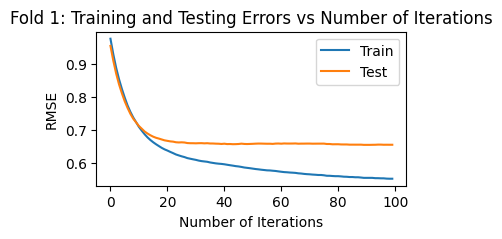


Fold 2: Max Predicted Value:  5.32 ; Min Predicted Value:  1.3 ; Fold RMSE: 0.64


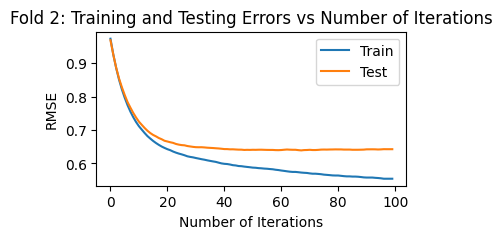


Fold 3: Max Predicted Value:  5.34 ; Min Predicted Value:  1.24 ; Fold RMSE: 0.63


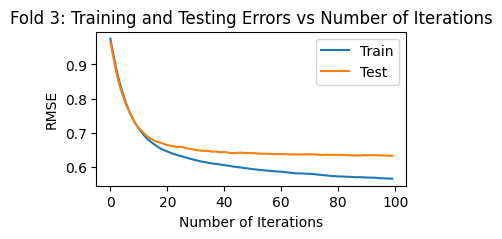


Fold 4: Max Predicted Value:  5.24 ; Min Predicted Value:  1.52 ; Fold RMSE: 0.67


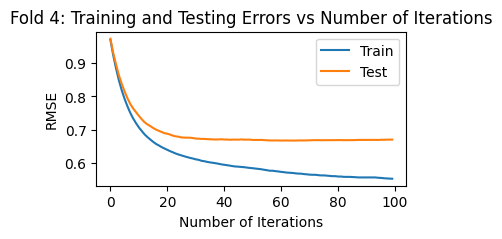


Fold 5: Max Predicted Value:  5.28 ; Min Predicted Value:  1.54 ; Fold RMSE: 0.67


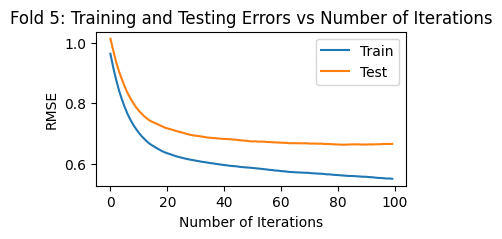


Cross-validation RMSE scores: [0.66, 0.64, 0.63, 0.67, 0.67]

Mean RMSE: 0.654


In [116]:
from sklearn.model_selection import KFold
from xgboost import XGBRegressor

X = simplified_train_logs[['num_events',
                           'chars_per_min_process', 
                           'words_per_min_product',
                           'sentences_per_min_product',
                           'pause_time_proportion_perc',
                           'mean_pause_length_w_in_words',
                          'len_essay', 'num_spaces',
       'num_?', 'num_.', 'num_"', 'num_;', 'num_punctuation']]

y = train_scores.score

# Set the number of folds
num_folds = 5

# Instantiate the KFold cross-validator
kf = KFold(n_splits=num_folds, shuffle=True, random_state=SEED)

# Initialize lists to store results
rmse_scores = []

regr = XGBRegressor(alpha=0.3, colsample_bytree=0.9, gamma=1, 
                    learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8, random_state=SEED)

# Perform cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the model on the training data
    regr.fit(X_train, y_train, eval_metric="rmse", eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)

    # Get training and testing errors for each iteration of the current fold
    train_errors_fold = regr.evals_result()["validation_0"]["rmse"]
    test_errors_fold = regr.evals_result()["validation_1"]["rmse"]

    # Make predictions on the test data
    y_pred = regr.predict(X_test)

    # Calculate RMSE for the fold
    rmse = np.round(np.sqrt(((y_test - y_pred) ** 2).mean()), 2)
    rmse_scores.append(rmse)

    # Print results for each fold
    print(f"\nFold {fold}: Max Predicted Value: ", np.round(np.max(y_pred), 2), "; Min Predicted Value: ", np.round(np.min(y_pred), 2), f"; Fold RMSE: {rmse}")

    # Plot training and testing errors for the current fold
    fig, ax = plt.subplots(figsize=(4, 2))
    ax.plot(train_errors_fold, label='Train')
    ax.plot(test_errors_fold, label='Test')
    ax.set_xlabel('Number of Iterations')
    ax.set_ylabel('RMSE')
    ax.legend()
    plt.title(f'Fold {fold}: Training and Testing Errors vs Number of Iterations')
    plt.show()

# Print average RMSE across all folds
print(f"\nCross-validation RMSE scores: {rmse_scores}")
print(f"\nMean RMSE: {np.round(np.mean(rmse_scores), 3)}")

Submission with the last model obtained a score of 0.684, roughly the same obtained here with cross-validation: 0.684 vs 0.68

The best submission so far, using the Baseline Random Forest Regressor, had a much greater variance:

In [117]:
print(f"Variance for Baseline Random Forest Regressor: {np.round(np.var([0.61, 0.73, 0.68, 0.71, 0.66]),4)}", 
      f"\n\t Variance for last XGB Regressor model: {np.round(np.var([0.69, 0.68, 0.65, 0.69, 0.71]),4)}")

Variance for Baseline Random Forest Regressor: 0.0017 
	 Variance for last XGB Regressor model: 0.0004


Perhaps that explains why the submission score was clearly superior to the cross-validation score in that case, while in the other cases it's staying consistent.

### Experiments with a Classification approach

Classification approaches are compatible with Stratification, which might have a positive impact in the predictive skills of the model. 

The target variable will be modified to make it suitable for classification.

In [118]:
# train_scores['score_cat'] = (2 * train_scores.score) - 1
# train_scores.score_cat = pd.Categorical(train_scores.score_cat, sorted(train_scores.score_cat.unique()), ordered=True)
# print('Changing type to Categorical:\n', train_scores.score_cat.unique())

Output of previous cell: 

    Changing type to Categorical:
     [6.0, 11.0, 3.0, 7.0, 8.0, ..., 5.0, 2.0, 10.0, 1.0, 0.0]


    Length: 12

    Categories (12, float64): [0.0 < 1.0 < 2.0 < 3.0 ... 8.0 < 9.0 < 10.0 < 11.0]

#### XGBoost Classifier with same features, without hyperparameters

In [119]:
# from sklearn.model_selection import StratifiedKFold, cross_val_predict, cross_val_score
# from xgboost import XGBClassifier
# from sklearn.metrics import make_scorer, confusion_matrix, accuracy_score

# xgb_classifier = XGBClassifier(random_state=SEED)

# X = simplified_train_logs[['num_events', 'chars_per_min_process', 'words_per_min_product',
#        'sentences_per_min_product', 'pause_time_proportion_perc',
#        'mean_pause_length_w_in_words']]

# y = train_scores.score

# num_folds = 5
# skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=SEED)

# # Define custom scorer for accuracy
# accuracy_scorer = make_scorer(accuracy_score)

# cv_scores = cross_val_score(xgb_classifier, X, y, cv=skf, scoring=accuracy_scorer)
# print("\nCross-validation Accuracy scores:", cv_scores)
# print("Mean Accuracy:", np.round(cv_scores.mean(), 2))

# # Additional step for Mean RMSE calculation
# # Define custom scorer for RMSE
# rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)
# cv_rmse_scores = cross_val_score(xgb_classifier, X, y, cv=skf, scoring=rmse_scorer)
# print("\nCross-validation RMSE scores:", -cv_rmse_scores)  # Negate scores since make_scorer uses greater_is_better=False
# print("Mean RMSE:", np.round(-cv_rmse_scores.mean(), 2))  # Negate mean as well


Results for previous cell:

    Cross-validation Accuracy scores: [0.29, 0.31, 0.26, 0.28, 0.29]

    Mean Accuracy: 0.29

    Cross-validation RMSE scores: [1.73, 1.62, 1.66, 1.67, 1.61]

    Mean RMSE: 1.66

#### XGBoost Classifier with same features and same hyperparameters

In [120]:
# from sklearn.model_selection import StratifiedKFold, cross_val_predict, cross_val_score
# from xgboost import XGBClassifier
# from sklearn.metrics import make_scorer, confusion_matrix, accuracy_score

# xgb_classifier = XGBClassifier(alpha=0.3, colsample_bytree=0.9, gamma=1, learning_rate=0.1, 
#                                 max_depth=3, n_estimators=100, subsample=0.8, random_state=SEED)

# X = simplified_train_logs[['num_events', 'chars_per_min_process', 'words_per_min_product',
#        'sentences_per_min_product', 'pause_time_proportion_perc',
#        'mean_pause_length_w_in_words']]

# y = train_scores.score

# num_folds = 5
# skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=SEED)

# # Define custom scorer for accuracy
# accuracy_scorer = make_scorer(accuracy_score)

# cv_scores = cross_val_score(xgb_classifier, X, y, cv=skf, scoring=accuracy_scorer)
# print("\nCross-validation Accuracy scores:", cv_scores)
# print("Mean Accuracy:", np.round(cv_scores.mean(), 2))

# # Additional step for Mean RMSE calculation
# # Define custom scorer for RMSE
# rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)
# cv_rmse_scores = cross_val_score(xgb_classifier, X, y, cv=skf, scoring=rmse_scorer)
# print("\nCross-validation RMSE scores:", -cv_rmse_scores)  # Negate scores since make_scorer uses greater_is_better=False
# print("Mean RMSE:", np.round(-cv_rmse_scores.mean(), 2))  # Negate mean as well


Results for previous cell:

    Cross-validation Accuracy scores: [0.31, 0.33, 0.28, 0.30, 0.30]

    Mean Accuracy: 0.3

    Cross-validation RMSE scores: [1.59, 1.50,  1.54, 1.51, 1.50]

    Mean RMSE: 1.52

Both Mean RMSE scores are far worse than those produced by the Regression Models we had built so far. 

It could be the case that this classification algorithm performed better with a different set of features. Experiment dismissed, regardless.

##### Functions used to constrain predictions (not useful so far)

In [121]:
# Functions to constrain predictions
# def discretize(predictions):
#     score_values = np.array(sorted(train_scores.score.unique()))
#     closest_values = score_values[np.argmin(np.abs(predictions[:, np.newaxis] - score_values), axis=1)]
#     return closest_values

# def modify_array(arr):
#     modified_arr = [min(max(value, 0.5), 6) for value in arr]
#     return modified_arr

# def sigmoid_transform(x):
#     k = 2  
#     c = 3.5
#     a = 5.5  
#     b = 0.5

#     sigmoid_result = 1 / (1 + np.exp(-k * (x - c)))
#     transformed_result = a * sigmoid_result + b

#     return transformed_result

#### Brief description of other experiments

In [122]:
# Create several bin variables for each of the 6 features
# None of them could help improve the score. It deteriorated in most cases

In [123]:
# Create new variable subtracting Nonproduction time from sum of action time - not helpful

In [124]:
# Tried sorting the imbalance in the target variable by using the parameter "sample_weight" in xgb's fit method. 
# The model predicted values closer to the extremes, still not reaching either 0.5 or 6. The score deteriorated.
# Tried the same with XGB Classifier. Worse

## Preparation for submission

In [125]:
regr.fit(X,y)      # Fitting the Model to the whole dataset

# Function to extract numbers from 'activity' values when value like 'Move...'
def extract_numbers(input_string):
    # Define a regular expression pattern to match the numbers inside square brackets
    pattern = r'\[(\d+),\s*(\d+)\]\s*To\s*\[(\d+),\s*(\d+)\]'

    match = re.search(pattern, input_string)

    num1, num2, num3, num4 = map(int, match.groups())
    return num1, num2, num3, num4

# Function to update the main string based on rules
def update_string(row, main_string, cursor_position_curr, cursor_position_prev):
    if row['activity'] == 'Input':
        main_string = main_string[:cursor_position_prev] + row['text_change'] + main_string[cursor_position_prev:]
    elif row['activity'] == 'Remove/Cut':
        start_pos = cursor_position_prev
        end_pos = cursor_position_curr
        main_string = main_string[:end_pos] + main_string[start_pos:]
    elif row['activity'] == 'Replace':
        replace_str = row['text_change']
        arrow_idx = replace_str.find(' => ')
        str_to_delete = replace_str[:arrow_idx]
        str_to_add = replace_str[arrow_idx+4:]
        main_string = main_string[:cursor_position_prev-len(str_to_delete)] + str_to_add + main_string[cursor_position_prev:]
    elif row['activity'] == 'Paste':
        str_to_add = row['text_change']
        main_string = main_string[:cursor_position_prev] + str_to_add + main_string[cursor_position_curr:]
    elif 'Move' in row['activity']:
        x1, y1, x2, y2 = extract_numbers(row.activity)
        str_to_move = row['text_change']
        main_string = main_string[:x1] + main_string[y1:]
        main_string = main_string[:x2] + str_to_move + main_string[y2:]
    return main_string



def transformations_train_test(df):     # Apply to test_logs the same transformations applied to train_logs

    id_groups = df.groupby('id')

    df['num_events'] = id_groups['event_id'].transform('last')

    df['input_chars_aux'] = id_groups['activity'].transform(lambda x: (x == 'Input').sum())

    df['remove_cut_chars_aux'] = id_groups['activity'].transform(
        lambda x: (df.loc[x.index, 'text_change'][x == 'Remove/Cut']).str.len().sum()
    )

    df['paste_chars_aux'] = id_groups['activity'].transform(
        lambda x: (df.loc[x.index, 'text_change'][x == 'Paste']).str.len().sum()
    )

    df['total_time_mins'] = np.round(id_groups['up_time'].transform('last') / 60000, 1)

    for _, group in id_groups:
        first_strings_replace_chars = 0
        second_strings_replace_chars = 0

        for replace_str in group[group.activity == "Replace"].text_change.values:
            arrow_idx = replace_str.find(' => ')
            first_strings_replace_chars += arrow_idx
            len_second_str = len(replace_str) - arrow_idx - len(' => ')
            second_strings_replace_chars += len_second_str

        df.loc[group.index, 'first_strings_replace_chars_aux'] = first_strings_replace_chars
        df.loc[group.index, 'second_strings_replace_chars_aux'] = second_strings_replace_chars

    df['chars_product'] = df.input_chars_aux - df.remove_cut_chars_aux - \
                          df.first_strings_replace_chars_aux + df.second_strings_replace_chars_aux + df.paste_chars_aux

    df['chars_process'] = df.input_chars_aux + df.second_strings_replace_chars_aux + \
                         df.paste_chars_aux
    df['chars_per_min_process'] = np.round(df.chars_process / df.total_time_mins, 1)


    df['last_word_count_aux'] = id_groups['word_count'].transform(lambda x: x.values[-1])
    df['words_per_min_product'] = np.round(df.last_word_count_aux / df.total_time_mins, 1)

    for _, group in id_groups:
        diff_word_count = group['word_count'].shift(1) - group['word_count']
        num_deleted_words = np.maximum(0, diff_word_count).sum()

        input_sentences = group[(group['text_change'].str.contains('[\.\;\?\!\:]', regex=True)) &
                                    (group.activity=='Input')].event_id.count()

        remove_cut_sentences = group[(group['text_change'].str.contains('[\.\;\?\!\:]', regex=True)) &
                                    (group.activity=='Remove/Cut')].event_id.count()

        input_paragraphs = group[(group.activity=='Input') & (group.text_change.str.contains('\n'))].event_id.count()

        df.loc[group.index, 'num_deleted_words_aux'] = num_deleted_words
        df.loc[group.index, 'input_sentences_aux'] = input_sentences
        df.loc[group.index, 'remove_cut_sentences_aux'] = remove_cut_sentences
        df.loc[group.index, 'input_paragraphs_aux'] = input_paragraphs

    sentences_process = df.input_sentences_aux
    sentences_product = df.input_sentences_aux - df.remove_cut_sentences_aux
    paragraphs_process = df.input_paragraphs_aux

    df = (
        df.assign(
            total_words_aux=lambda x: x['last_word_count_aux'] + x['num_deleted_words_aux'],
            sentences_per_min_product=lambda x: x['input_sentences_aux'] - \
                                                 x['remove_cut_sentences_aux'] / x['total_time_mins']
        )
        .round(1)
    )

    for _, group in id_groups:
        iki = group['down_time'] - group['up_time'].shift(1)
        filtered_iki = [num for num in iki if num >= 2000]
        num_pauses = len(filtered_iki)
        pause_time = sum(filtered_iki)

        # Assign accumulated values to the corresponding columns for the group
        df.loc[group.index, 'num_pauses'] = num_pauses
        df.loc[group.index, 'pause_time_aux'] = pause_time  

    df = (
        df.assign(
            pause_time_proportion_perc=np.round((100 * df.pause_time_aux) / (60000 * df.total_time_mins), 1)
        )
        .round(1)
    )

    for _, group in id_groups:
        group['word_count_up_aux'] = group.word_count > group.shift().word_count
        word_count_up_idxs = group[(group.word_count_up_aux) & (group.text_change=='q')].index

        pause_time_w_in_words, pauses_w_in_words = 0, 0
        for idx in word_count_up_idxs:
            initial_time = group.at[idx, 'up_time']
            slice_f = group[(group.index >= idx + 1) & (group.index <= idx + 10) 
                            & (group.activity=='Input') & (group.text_change.isin(['.', ',', ';', ':', ' ', '!', '?']))] 
            if not slice_f.empty:
                final_time = slice_f['down_time'].values[0]
                pause_time_w_in_words += final_time - initial_time
                pauses_w_in_words += 1

        df.loc[group.index, 'pause_time_w_in_words_aux'] = pause_time_w_in_words
        if pauses_w_in_words == 0:
            df.loc[group.index, 'pauses_w_in_words_aux'] = np.nan
        else:
            df.loc[group.index, 'pauses_w_in_words_aux'] = pauses_w_in_words

    df['mean_pause_length_w_in_words'] = np.round(df.pause_time_w_in_words_aux / \
                                                  df.pauses_w_in_words_aux, 1)
    
    # Create a new column 'coded_essay_str'
    df['coded_essay_str'] = ''

    # Iterate over unique 'id' values and update main_string for each group
    for unique_id in df['id'].unique():
        main_string = ''
        # Initialize cursor_position
        cursor_position_prev = 0
        # Iterate over rows with the current 'id'
        for index, row in df[df['id'] == unique_id].iterrows():
            cursor_position_curr = row['cursor_position']
            main_string = update_string(row, main_string, cursor_position_curr, cursor_position_prev)
            cursor_position_prev = cursor_position_curr

        # Assign the final main_string to the 'coded_essay_str' column for the current 'id'
        df.loc[df['id'] == unique_id, 'coded_essay_str'] = main_string

    # New features related to coded_essay_str
    import string
    df['len_essay'] = df['coded_essay_str'].apply(len)
    df['num_spaces'] = df['coded_essay_str'].apply(lambda x: x.count(' '))
    df['num_?'] = df['coded_essay_str'].apply(lambda x: x.count('?'))
    df['num_.'] = df['coded_essay_str'].apply(lambda x: x.count('.'))
    df['num_"'] = df['coded_essay_str'].apply(lambda x: x.count('"'))
    df['num_;'] = df['coded_essay_str'].apply(lambda x: x.count(';'))
    df['num_punctuation'] = df['coded_essay_str'].apply(lambda x: sum(x.count(p) for p in string.punctuation))


    df = df.filter(regex='^(?!.*aux).*$')
    df.drop(redundant_vars, axis=1, inplace=True)
    simplified_df = df.drop(original_cols_ex_id, axis=1)
    simplified_df.drop_duplicates(inplace=True)
    simplified_df.reset_index(drop=True, inplace=True)
    simplified_df.fillna(0, inplace=True)
    return simplified_df


test_logs_transformed = transformations_train_test(test_logs)
predictions = regr.predict(test_logs_transformed[['num_events', 'chars_per_min_process',
                                                  'words_per_min_product', 'sentences_per_min_product',
                                                  'pause_time_proportion_perc', 'mean_pause_length_w_in_words',
                                                  'len_essay', 'num_spaces', 'num_?', 'num_.', 'num_"', 'num_;', 
                                                  'num_punctuation']])

# Constrain predictions to the nearest possible target value.
# def discretize(predictions):
#     score_values = np.array(sorted(train_scores.score.unique()))
    
#     closest_values = score_values[np.argmin(np.abs(predictions[:, np.newaxis] - score_values), axis=1)]

#     return closest_values

# rounded_predictions = discretize(predictions)

test_logs_transformed['score'] = predictions
test_logs_transformed[['id', 'score']].to_csv('./submission.csv', index=False)